# Reto MA2003B - Calidad del Aire y Contaminantes ZMM
- Gabriel Villanueva de Araujo Souza - A01781585
- Hildegard Zerrweck García - A00838300
- Julio Chárbel Porras Osorio - A01736268

In [1]:
# Librerías optimizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scipy
from scipy.stats import yeojohnson, kstest, norm

# Statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import re



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# LIMPIEZA

## Compilación Datos no Limpios

In [2]:

base = Path("/Users/gabrielvas/Desktop/Aplicacion_metodosmultivariados_Reto")
stations = ["CENTRO", "NORTE", "SUROESTE", "SUROESTE2", "SURESTE3", "NORESTE2", "NORTE2"]
year_files = {
    2022: base / "DATOS_HISTORICOS_2022.xlsx",
    2023: base / "DATOS_HISTORICOS_2023.xlsx",
    2024: base / "DATOS_HISTORICOS_2024.xlsx",
    2025: base / "DATOS_HISTORICOS_2025.xlsx",
}

raw_series = {station: [] for station in stations}

columns_to_drop = ['RAINF', 'RH', 'PRS']

for year, file in year_files.items():
    yearly_raw = pd.read_excel(file, sheet_name=stations)  # sin limpieza
    for station in stations:
        df_station = yearly_raw[station].copy()
        # Eliminar columnas 'RAINF', 'RH', 'PRS' si existen
        df_station = df_station #.drop(columns=[col for col in columns_to_drop if col in df_station.columns], errors='ignore')
        df_station["date"] = pd.to_datetime(df_station["date"])
        df_station = df_station.set_index("date").sort_index()
        df_station["year"] = year           # opcional, ayuda a rastrear el origen
        raw_series[station].append(df_station)

df_por_estacion = {
    station: pd.concat(raw_series[station], axis=0)
    for station in stations
}

globals().update({
    f"df_{station}_22_25_nolimpio": df_por_estacion[station]
    for station in stations
})

# Ejemplo de verificación
for station in stations:
    print(station, df_por_estacion[station].shape)

CENTRO (30646, 16)
NORTE (30644, 16)
SUROESTE (30504, 16)
SUROESTE2 (30643, 16)
SURESTE3 (30643, 16)
NORESTE2 (30643, 16)
NORTE2 (30644, 16)


## Datos Limpios

### 2022

In [3]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2022.xlsx",
    sheet_name=stations
)

# Remover columnas que no usarás
for name in stations:
    raw_data[name] = raw_data[name].drop(columns=["RAINF",'NOX','WDR','WSR'])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 8),
    "NO": (0, 400),
    "NO2": (0, 175),
    "NOX": (0, 420),
    "O3": (0, 160),
    "PM10": (0, 999),
    "PM2.5": (0, 450),
    "SO2": (0, 200),
    "SR": (0, 1.25),
    "TOUT": (-5, 45),
    "WSR": (0, 35),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="time")

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in stations:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2022_{name}"] = temp_df

    print(f"Listo: df_2022_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2022_CENTRO creado (shape=(8760, 11))
Listo: df_2022_NORTE creado (shape=(8760, 11))
Listo: df_2022_SUROESTE creado (shape=(8760, 11))
Listo: df_2022_SUROESTE2 creado (shape=(8760, 11))
Listo: df_2022_SURESTE3 creado (shape=(8760, 11))
Listo: df_2022_NORESTE2 creado (shape=(8760, 11))
Listo: df_2022_NORTE2 creado (shape=(8760, 11))

--- PROCESO COMPLETO ---


### 2023

In [4]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2023.xlsx",
    sheet_name=stations
)

# Remover columnas que no usarás
for name in stations:
    raw_data[name] = raw_data[name].drop(columns=["RAINF",'NOX','WDR','WSR'])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 14),
    "NO": (0, 500),
    "NO2": (0, 175),
    "NOX": (0, 500),
    "O3": (0, 175),
    "PM10": (0, 900),
    "PM2.5": (0, 800),
    "SO2": (0, 250),
    "SR": (0, 1),
    "TOUT": (0, 45),
    "WSR": (0, 40),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="time")

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in stations:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2023_{name}"] = temp_df

    print(f"Listo: df_2023_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2023_CENTRO creado (shape=(8758, 11))
Listo: df_2023_NORTE creado (shape=(8758, 11))
Listo: df_2023_SUROESTE creado (shape=(8758, 11))
Listo: df_2023_SUROESTE2 creado (shape=(8758, 11))
Listo: df_2023_SURESTE3 creado (shape=(8758, 11))
Listo: df_2023_NORESTE2 creado (shape=(8758, 11))
Listo: df_2023_NORTE2 creado (shape=(8758, 11))

--- PROCESO COMPLETO ---


### 2024

In [5]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2024.xlsx",
    sheet_name=stations
)

# Remover columnas que no usarás
for name in stations:
    raw_data[name] = raw_data[name].drop(columns=["RAINF",'NOX','WDR','WSR'])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 18),
    "NO": (0, 400),
    "NO2": (0, 130),
    "NOX": (0, 500),
    "O3": (0, 180),
    "PM10": (0, 999),
    "PM2.5": (0, 999),
    "SO2": (0, 150),
    "SR": (0, 1.26),
    "TOUT": (-4, 45.5),
    "WSR": (0, 38),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="time")

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in stations:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2024_{name}"] = temp_df

    print(f"Listo: df_2024_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")


Listo: df_2024_CENTRO creado (shape=(8784, 11))
Listo: df_2024_NORTE creado (shape=(8782, 11))
Listo: df_2024_SUROESTE creado (shape=(8784, 11))
Listo: df_2024_SUROESTE2 creado (shape=(8782, 11))
Listo: df_2024_SURESTE3 creado (shape=(8782, 11))
Listo: df_2024_NORESTE2 creado (shape=(8782, 11))
Listo: df_2024_NORTE2 creado (shape=(8782, 11))

--- PROCESO COMPLETO ---


### 2025

In [6]:
# ============================
# 1. CARGAR DATOS
# ============================

raw_data = pd.read_excel(
    "DATOS_HISTORICOS_2025.xlsx",
    sheet_name=stations
)

# Remover columnas que no usarás
for name in stations:
    raw_data[name] = raw_data[name].drop(columns=["RAINF",'NOX','WDR','WSR'])


# ============================
# 2. RANGOS PERMITIDOS
# ============================

ranges = {
    "CO": (0, 10),
    "NO": (0, 350),
    "NO2": (0, 175),
    "NOX": (0, 400),
    "O3": (0, 185),
    "PM10": (0, 820),
    "PM2.5": (0, 350),
    "SO2": (0, 405),
    "SR": (0, 1.2),
    "TOUT": (-4.5, 45),
    "WSR": (0, 40),
    "WDR": (0, 360)
}


# ============================
# 3. FUNCIÓN: ELIMINAR FUERA DE RANGO
# ============================

def clean_out_of_range(df):
    for col, (low, high) in ranges.items():
        if col in df.columns:
            df.loc[(df[col] < low) | (df[col] > high), col] = np.nan
    return df


# ============================
# 4. FUNCIÓN: IMPUTACIÓN COMPLETA
# ============================

def impute_df(df):

    # Asegurar índice de tiempo
    df.index = pd.to_datetime(df.index)

    # ----------------------------
    # Gases reactivos — interpolación temporal
    # ----------------------------
    gases_time = ["CO", "NO", "NO2", "NOX", "O3", "SO2"]
    for col in gases_time:
        if col in df.columns:
            df[col] = df[col].interpolate(method="time")

    # ----------------------------
    # Material particulado
    # ----------------------------
    if "PM10" in df.columns:
        df["PM10"] = df["PM10"].interpolate(method="linear")

    if "PM2.5" in df.columns:
        df["PM2.5"] = df["PM2.5"].interpolate(method="linear")

    # ----------------------------
    # Meteorológicas suaves
    # ----------------------------
    if "TOUT" in df.columns:
        df["TOUT"] = df["TOUT"].interpolate(method="time")

    if "SR" in df.columns:
        df["SR"] = df["SR"].interpolate(method="time")

    # ----------------------------
    # Velocidad del viento — mediana móvil
    # ----------------------------
    if "WSR" in df.columns:
        df["WSR"] = df["WSR"].fillna(df["WSR"].rolling(5, min_periods=1).median())

    # ----------------------------
    # Dirección del viento — imputación circular
    # ----------------------------
    if "WDR" in df.columns:
        rad = np.deg2rad(df["WDR"])
        df["WDR_sin"] = np.sin(rad)
        df["WDR_cos"] = np.cos(rad)

        df["WDR_sin"] = df["WDR_sin"].interpolate(method="time")
        df["WDR_cos"] = df["WDR_cos"].interpolate(method="time")

        df["WDR"] = np.rad2deg(np.arctan2(df["WDR_sin"], df["WDR_cos"]))
        df["WDR"] = (df["WDR"] + 360) % 360

        df = df.drop(columns=["WDR_sin", "WDR_cos"])

    # ----------------------------
    # Limpieza final
    # ----------------------------
    df = df.ffill().bfill()
    df = df.round(2)

    return df


# ============================
# 5. PROCESAR CADA SHEET Y CREAR DF FINAL
# ============================

for name in stations:
    temp_df = raw_data[name].copy()

    # Usar fecha como índice
    temp_df["date"] = pd.to_datetime(temp_df["date"])
    temp_df = temp_df.set_index("date")

    # Quitar valores fuera de rango
    temp_df = clean_out_of_range(temp_df)

    # Imputar con tu lógica avanzada
    temp_df = impute_df(temp_df)

    # Crear la variable global df_2022_NOMBRE
    globals()[f"df_2025_{name}"] = temp_df

    print(f"Listo: df_2025_{name} creado (shape={temp_df.shape})")


print("\n--- PROCESO COMPLETO ---")

Listo: df_2025_CENTRO creado (shape=(4344, 11))
Listo: df_2025_NORTE creado (shape=(4344, 11))
Listo: df_2025_SUROESTE creado (shape=(4202, 11))
Listo: df_2025_SUROESTE2 creado (shape=(4343, 11))
Listo: df_2025_SURESTE3 creado (shape=(4343, 11))
Listo: df_2025_NORESTE2 creado (shape=(4343, 11))
Listo: df_2025_NORTE2 creado (shape=(4344, 11))

--- PROCESO COMPLETO ---


### Compilación Datos Limpiados

In [7]:
# Concatenar DataFrames por estación a través de 2022–2025

pattern = re.compile(r"^df_(2022|2023|2024|2025)_(.+)$")

frames_by_station: dict[str, list[tuple[int, pd.DataFrame]]] = {}
# Importante: iterar sobre una copia estática de globals() para evitar
# "RuntimeError: dictionary changed size during iteration"
for var_name, obj in list(globals().items()):
    if isinstance(obj, pd.DataFrame):
        m = pattern.match(var_name)
        if m:
            year = int(m.group(1))
            station = m.group(2)
            frames_by_station.setdefault(station, []).append((year, obj))

combined_by_station: dict[str, pd.DataFrame] = {}
for station, items in frames_by_station.items():
    # Ordenar por año
    items_sorted = sorted(items, key=lambda x: x[0])
    frames = [df for _, df in items_sorted]

    # Alinear columnas (unión en el primer orden encontrado)
    ordered_union_cols: list[str] = []
    seen_cols: set[str] = set()
    for df in frames:
        for c in df.columns:
            if c not in seen_cols:
                seen_cols.add(c)
                ordered_union_cols.append(c)

    aligned_frames = [df.reindex(columns=ordered_union_cols) for df in frames]
    combined_df = pd.concat(aligned_frames, sort=False)
    combined_df = combined_df.sort_index()

    var_name = f"df_{station}_22_25"  # Nota: guiones no válidos en nombres de variables
    globals()[var_name] = combined_df
    combined_by_station[station] = combined_df

    print(f"Creado {var_name}: shape={combined_df.shape} | años={[y for y, _ in items_sorted]}")

   # # Guardar el DataFrame combinado a CSV
   # try:
   #     combined_df.to_csv(f"{var_name}.csv")
   #     print(f" → Guardado como {var_name}.csv")
   # except Exception as e:
   #     print(f"Error al guardar {var_name}.csv:", e)

# Acceso también vía diccionario
df_22_25_by_station = combined_by_station
print(f"\nEstaciones combinadas: {list(df_22_25_by_station.keys())}")


Creado df_CENTRO_22_25: shape=(30646, 11) | años=[2022, 2023, 2024, 2025]
Creado df_NORTE_22_25: shape=(30644, 11) | años=[2022, 2023, 2024, 2025]
Creado df_SUROESTE_22_25: shape=(30504, 11) | años=[2022, 2023, 2024, 2025]
Creado df_SUROESTE2_22_25: shape=(30643, 11) | años=[2022, 2023, 2024, 2025]
Creado df_SURESTE3_22_25: shape=(30643, 11) | años=[2022, 2023, 2024, 2025]
Creado df_NORESTE2_22_25: shape=(30643, 11) | años=[2022, 2023, 2024, 2025]
Creado df_NORTE2_22_25: shape=(30644, 11) | años=[2022, 2023, 2024, 2025]

Estaciones combinadas: ['CENTRO', 'NORTE', 'SUROESTE', 'SUROESTE2', 'SURESTE3', 'NORESTE2', 'NORTE2']


# ANÁLISIS MODELO ARIMA y ARIMAX

## URBANO

### CENTRO

In [36]:
# Crear un DataFrame de los promedios diarios para df_CENTRO_22_25
df_22_25_diario = df_CENTRO_22_25.copy()
df_22_25_diario.index = pd.to_datetime(df_22_25_diario.index)
df_22_25_diario = df_22_25_diario.resample("D").mean()
df_22_25_diario.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,1277.0,1.579731,0.739820,0.158750,1.002917,1.442917,2.067083,3.680000
NO,1277.0,9.039865,8.336963,1.316667,4.516667,5.985417,10.537500,101.604167
NO2,1277.0,16.997600,7.975153,2.675000,11.112500,15.292083,21.750000,56.050000
O3,1277.0,28.350013,10.269592,1.197917,21.383333,27.750000,34.666667,64.340417
PM10,1277.0,61.025374,24.809355,11.858333,43.958333,56.125000,72.958333,212.687500
PM2.5,1277.0,24.727508,11.784931,5.013333,16.032083,22.755417,31.275417,87.355000
PRS,1277.0,711.363798,3.416821,696.179167,709.191667,711.100000,713.337500,723.066667
RH,1277.0,54.335992,16.107559,7.000000,43.875000,54.375000,64.958333,94.000000
SO2,1277.0,4.665779,1.904199,1.547500,3.212500,4.420833,5.858333,20.920833
SR,1277.0,0.183104,0.083548,0.000000,0.134167,0.186250,0.240833,0.625417


#### ACF

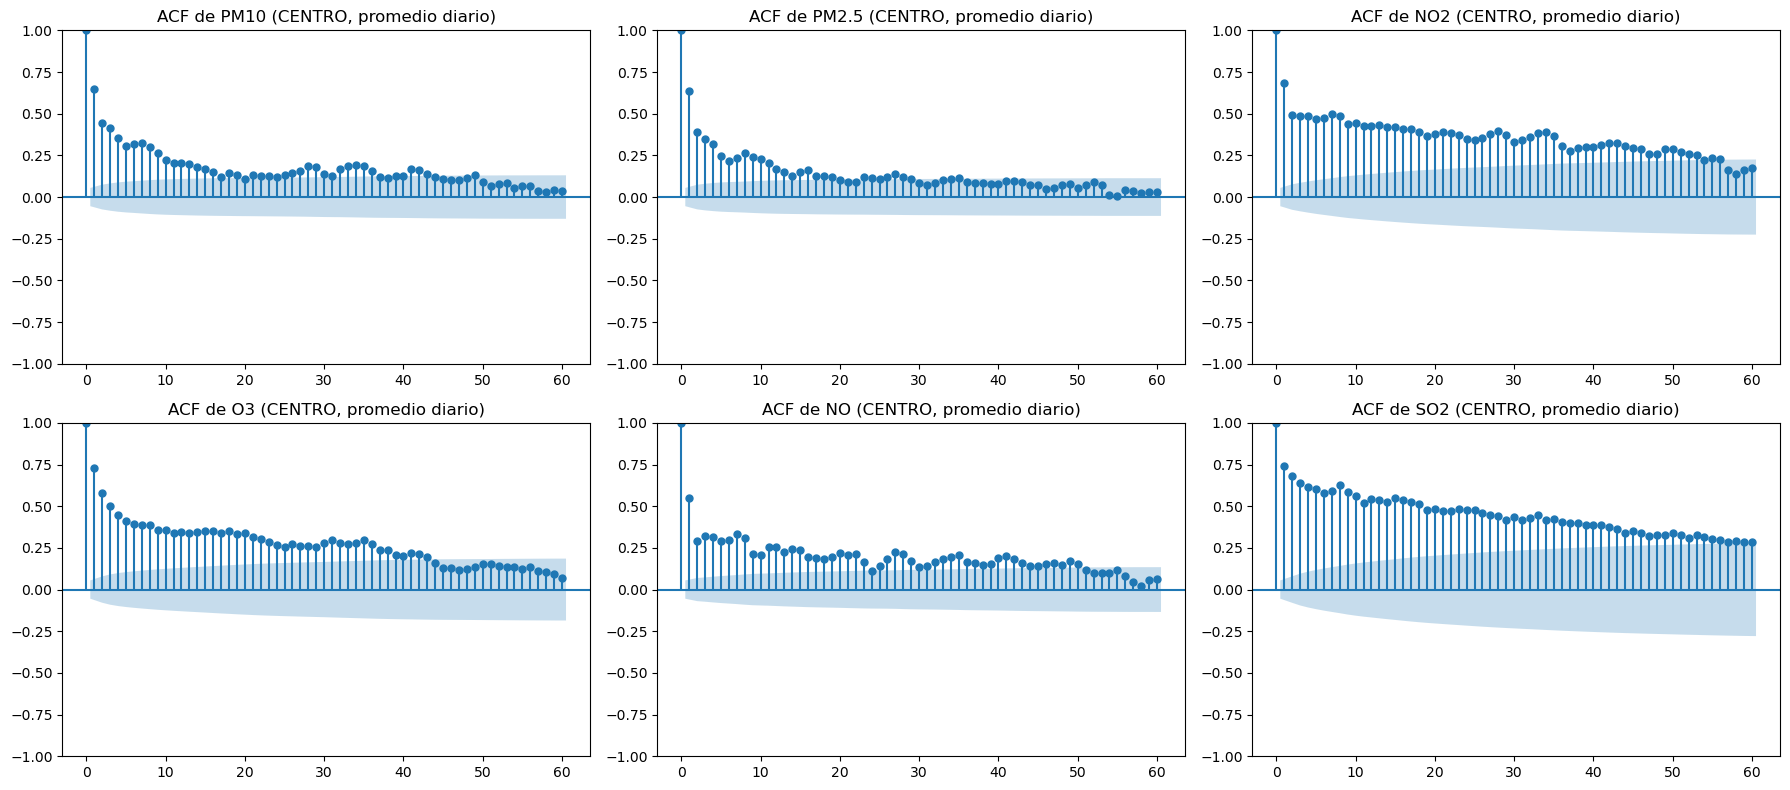

In [37]:
variables_analizar = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]

nrows, ncols = 2, 3  # 3 filas x 2 columnas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()  # aplanar para indexado sencillo

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_22_25_diario.columns:
        serie = df_22_25_diario[var].dropna()
        plot_acf(serie, ax=ax, lags=60, alpha=0.05)
        ax.set_title(f"ACF de {var} (CENTRO, promedio diario)")
    else:
        ax.set_visible(False)

# Oculta ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Los niveles diarios de todos estos contaminantes en la estación CENTRO no son independientes de un día a otro; muestran fuerte dependencia temporal y persistencia. Es decir, si un día hay niveles altos/bajos, es muy probable que en los días siguientes sigan siendo parecidos, y ese efecto puede durar varias semanas. Esto indica que las series son claramente no aleatorias y probablemente no estacionarias

#### PACF

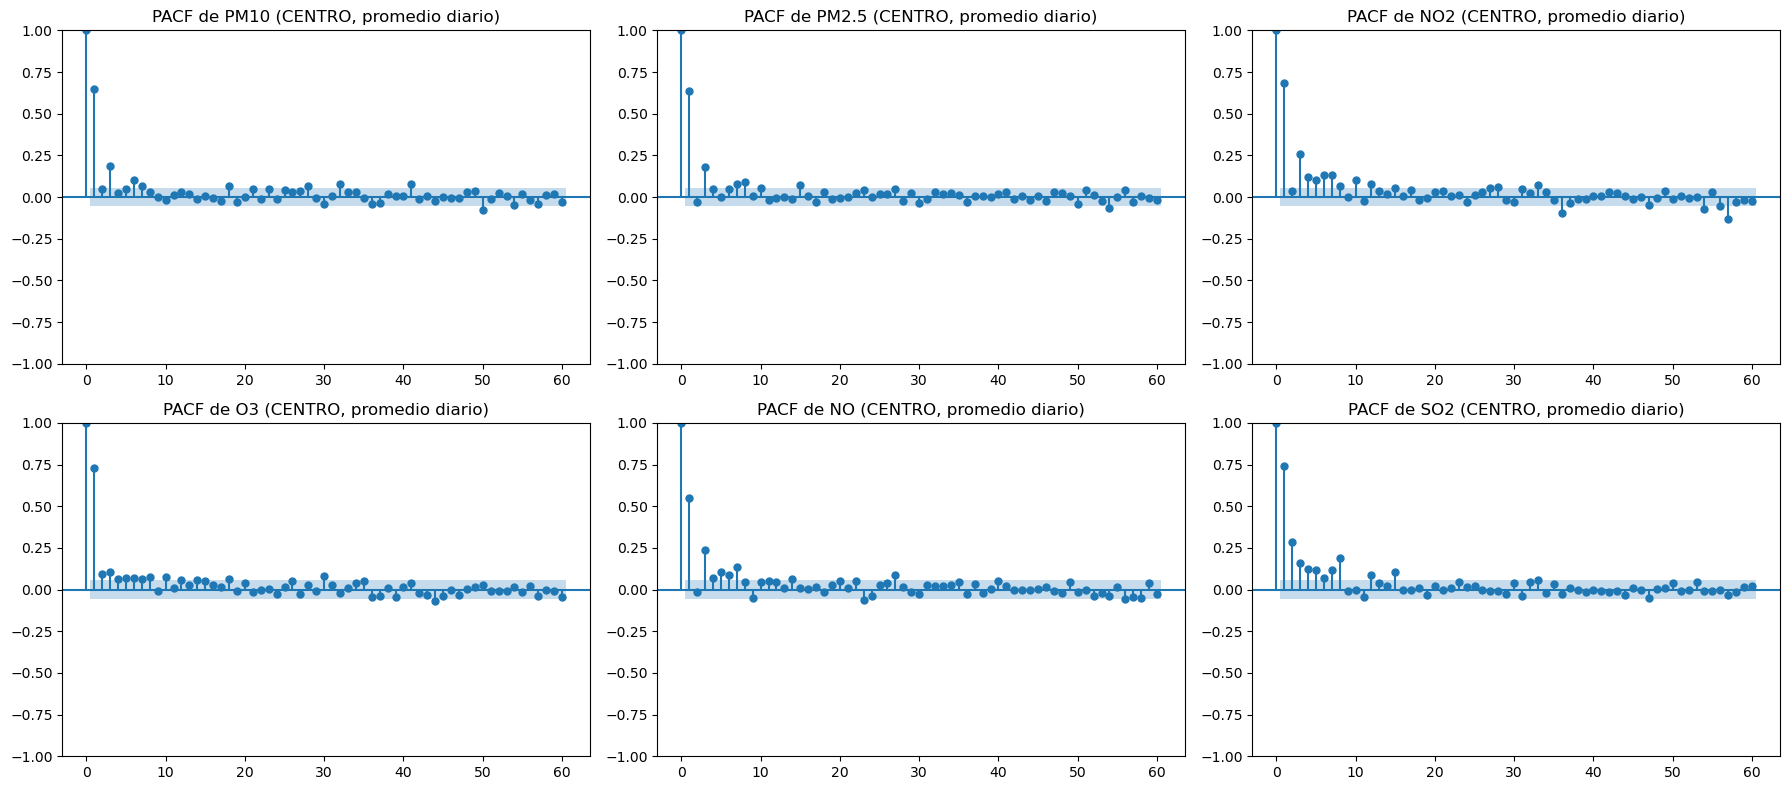

In [38]:
variables_analizar = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]

nrows, ncols = 2, 3  # 3 columnas x 2 filas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_22_25_diario.columns:
        serie = df_22_25_diario[var].dropna()
        plot_pacf(serie, ax=ax, lags=60, alpha=0.05, method='ywm')
        ax.set_title(f"PACF de {var} (CENTRO, promedio diario)")
    else:
        ax.set_visible(False)

# Ocultar ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


Los contaminantes diarios del CENTRO muestran que el valor de hoy depende principalmente del valor de 1 día antes (y muy poco de días más antiguos); para un modelo ARIMA, la PACF sugiere usar p ≈ 1 en la parte autorregresiva.

#### Modelo

In [39]:
# --- Configuración Inicial ---
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import os

contaminantes_lista = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]
meteo_cols = ["TOUT", "RH", "SR", "PRS"]

# Rangos para buscar el mejor modelo (Grid Search)
p_vals = [1, 2, 3] 
q_vals = [1, 2, 3]
d = 1
c = 1e-3  # Constante para evitar log(0)

resultados_finales = []
summary_dict = {}
graficas_path = "Centro_arimax_graficas"
os.makedirs(graficas_path, exist_ok=True)

resumen_lines = []
summary_lines = []

resumen_lines.append('Iniciando búsqueda de modelos ARIMAX para todos los contaminantes...\n')

for var in contaminantes_lista:
    if var not in df_22_25_diario.columns:
        mensaje = f"⚠️ Variable {var} no encontrada. Saltando..."
        resumen_lines.append(mensaje)
        continue
        
    mensaje = f"🔄 Procesando: {var}"
    resumen_lines.append(mensaje)
    
    # 1. Preparar datos (filtro y dropna)
    cols_necesarias = [var] + meteo_cols
    df_temp = df_22_25_diario[cols_necesarias].dropna()
    
    if df_temp.empty:
        mensaje = f"   Sin datos suficientes para {var}."
        resumen_lines.append(mensaje)
        continue
        
    # 2. Definir variables Endógena (y) y Exógenas (X)
    y_raw = df_temp[var]
    X = df_temp[meteo_cols]
    
    # Transformación Logarítmica
    y = np.log(y_raw + c)
    
    # Variables para guardar el mejor de este ciclo
    best_aic = np.inf
    best_order = None
    best_res = None
    
    # 3. Loop de Grid Search (p, q)
    for p in p_vals:
        for q in q_vals:
            try:
                model = ARIMA(y, exog=X, order=(p, d, q))
                res = model.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_res = res
                    best_order = (p, d, q)
            except Exception:
                continue
    
    # 4. Guardar el ganador en la lista de resultados y la summary
    if best_res is not None:
        y_pred_log = best_res.fittedvalues
        y_pred_real = np.exp(y_pred_log) - c
        y_raw_alineado = y_raw.loc[y_pred_real.index]
        
        try:
            mape = mean_absolute_percentage_error(y_raw_alineado, y_pred_real)
        except Exception:
            mape = np.nan
        try:
            cme = mean_squared_error(y_raw_alineado, y_pred_real)
            rmse = np.sqrt(cme)
        except Exception:
            cme, rmse = np.nan, np.nan
        
        resultados_finales.append({
            "Variable": var,
            "Mejor_p": best_order[0],
            "Mejor_d": best_order[1],
            "Mejor_q": best_order[2],
            "AIC": best_aic,
            "BIC": best_res.bic,
            "Var_Residuos": np.var(best_res.resid),
            "MAPE": mape,
            "CME": cme,
            "RMSE": rmse
        })
        resumen_txt = (
            f"   ✅ Ganador {var}: ARIMA{best_order} | "
            f"AIC: {best_aic:.2f} | MAPE: {mape:.3%} | CME: {cme:.3f}\n"
        )
        resumen_lines.append(resumen_txt)
        
        summary_txt = f"\n--- Modelo {var} ---\n\n{best_res.summary()}\n"
        summary_lines.append(summary_txt)
        
        # Guardar la gráfica en vez de mostrarla
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        y.plot(ax=ax[0], label='Observado (log)', color='blue')
        y_pred_log.plot(ax=ax[0], label='Ajuste ARIMAX (log)', color='red', alpha=0.7)
        ax[0].set_title(f"{var} (log) Observado vs Ajustado")
        ax[0].legend()

        y_raw.plot(ax=ax[1], label='Observado', color='blue')
        y_pred_real.plot(ax=ax[1], label='Ajuste ARIMAX', color='red', alpha=0.7)
        ax[1].set_title(f"{var} Observado vs Ajustado (escala original)")
        ax[1].legend()
        plt.tight_layout()
        figpath = os.path.join(graficas_path, f"arimax_{var}.png")
        plt.savefig(figpath)
        plt.close(fig)
        
    else:
        msg_no_conv = f"   ❌ No se encontró convergencia para {var}"
        resumen_lines.append(msg_no_conv)

resumen_lines.append("\n--- PROCESO TERMINADO ---")

# Mostrar DataFrame final
df_resultados_arimax_todos = pd.DataFrame(resultados_finales)

if not df_resultados_arimax_todos.empty:
    resumen_lines.append('\nResumen de métricas seleccionadas:\n')
    resumen_lines.append(df_resultados_arimax_todos.to_string(index=False))
else:
    resumen_lines.append("No hubo resultados para mostrar.")

# Guardar todo en un archivo .txt para descarga
salida_txt = "\n".join(resumen_lines)
summary_txt_total = "\n".join(summary_lines)
with open("Centro_resumen_arimax_resultados.txt", "w", encoding="utf-8") as f:
    f.write(salida_txt)
    f.write('\n\n')
    f.write(summary_txt_total)

# Guardar DataFrame en Excel para descarga
df_resultados_arimax_todos.to_excel("Centro_resumen_arimax_resultados.xlsx", index=False)

# Instrucción para el usuario (no imprimir nada aquí)
# Los resultados y resúmenes están guardados en:
# - resumen_arimax_resultados.txt
# - resumen_arimax_resultados.xlsx
# - Carpeta 'arimax_graficas/' con las imágenes de los ajustes


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### SUROESTE 2 

In [28]:
df_22_25_diario = df_SUROESTE2_22_25.copy()
df_22_25_diario.index = pd.to_datetime(df_22_25_diario.index)
df_22_25_diario = df_22_25_diario.resample("D").mean()
df_22_25_diario.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,1277.0,1.259263,0.851748,0.050000,0.610417,1.009167,1.785833,5.189167
NO,1277.0,8.380398,8.406299,1.429167,4.662500,5.925000,8.970833,138.939583
NO2,1277.0,16.778433,6.876577,3.437500,11.797917,15.450000,20.716667,48.354167
O3,1277.0,28.207875,11.778652,1.237500,20.291667,27.229167,35.208333,96.831250
PM10,1277.0,64.862254,49.723607,11.541667,43.208333,55.625000,75.500000,886.897083
PM2.5,1277.0,18.099155,7.837336,3.886667,12.270833,16.833333,22.541667,59.958333
PRS,1277.0,713.833039,1.459520,709.441667,712.895833,713.733333,714.720833,718.675000
RH,1277.0,53.486769,16.068771,7.083333,43.916667,53.750000,64.250000,90.000000
SO2,1277.0,4.479790,1.606842,0.559583,3.441667,4.179167,5.245833,18.483333
SR,1277.0,0.166216,0.067432,0.000000,0.122500,0.169583,0.220833,0.284167


#### ACF

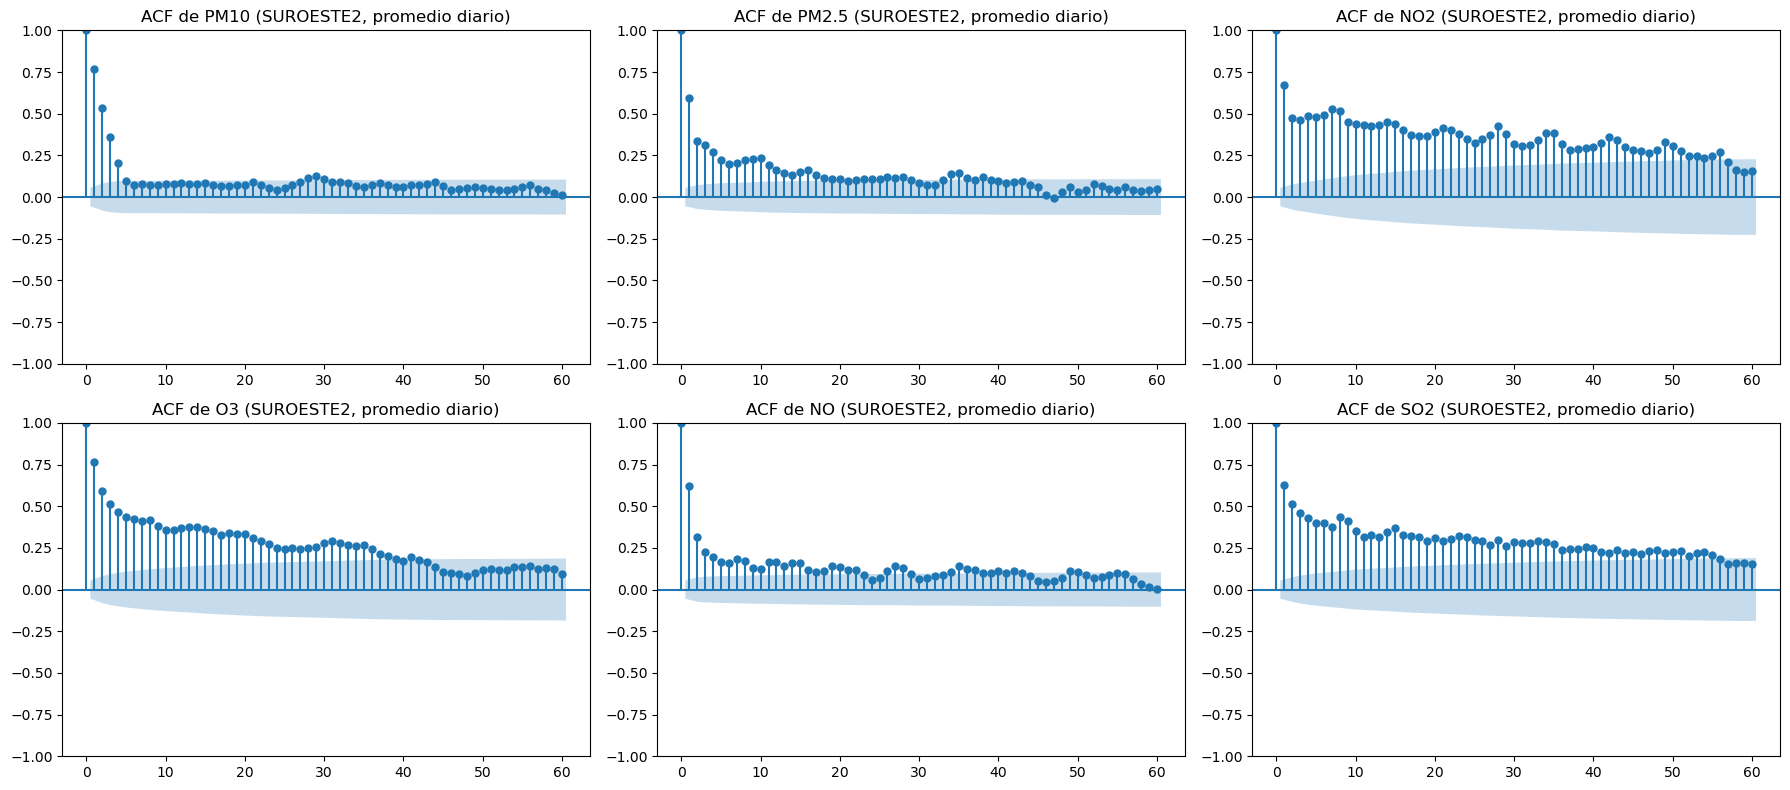

In [29]:
variables_analizar = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]

nrows, ncols = 2, 3  # 3 filas x 2 columnas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()  # aplanar para indexado sencillo

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_22_25_diario.columns:
        serie = df_22_25_diario[var].dropna()
        plot_acf(serie, ax=ax, lags=60, alpha=0.05)
        ax.set_title(f"ACF de {var} (SUROESTE2, promedio diario)")
    else:
        ax.set_visible(False)

# Oculta ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

#### PACF

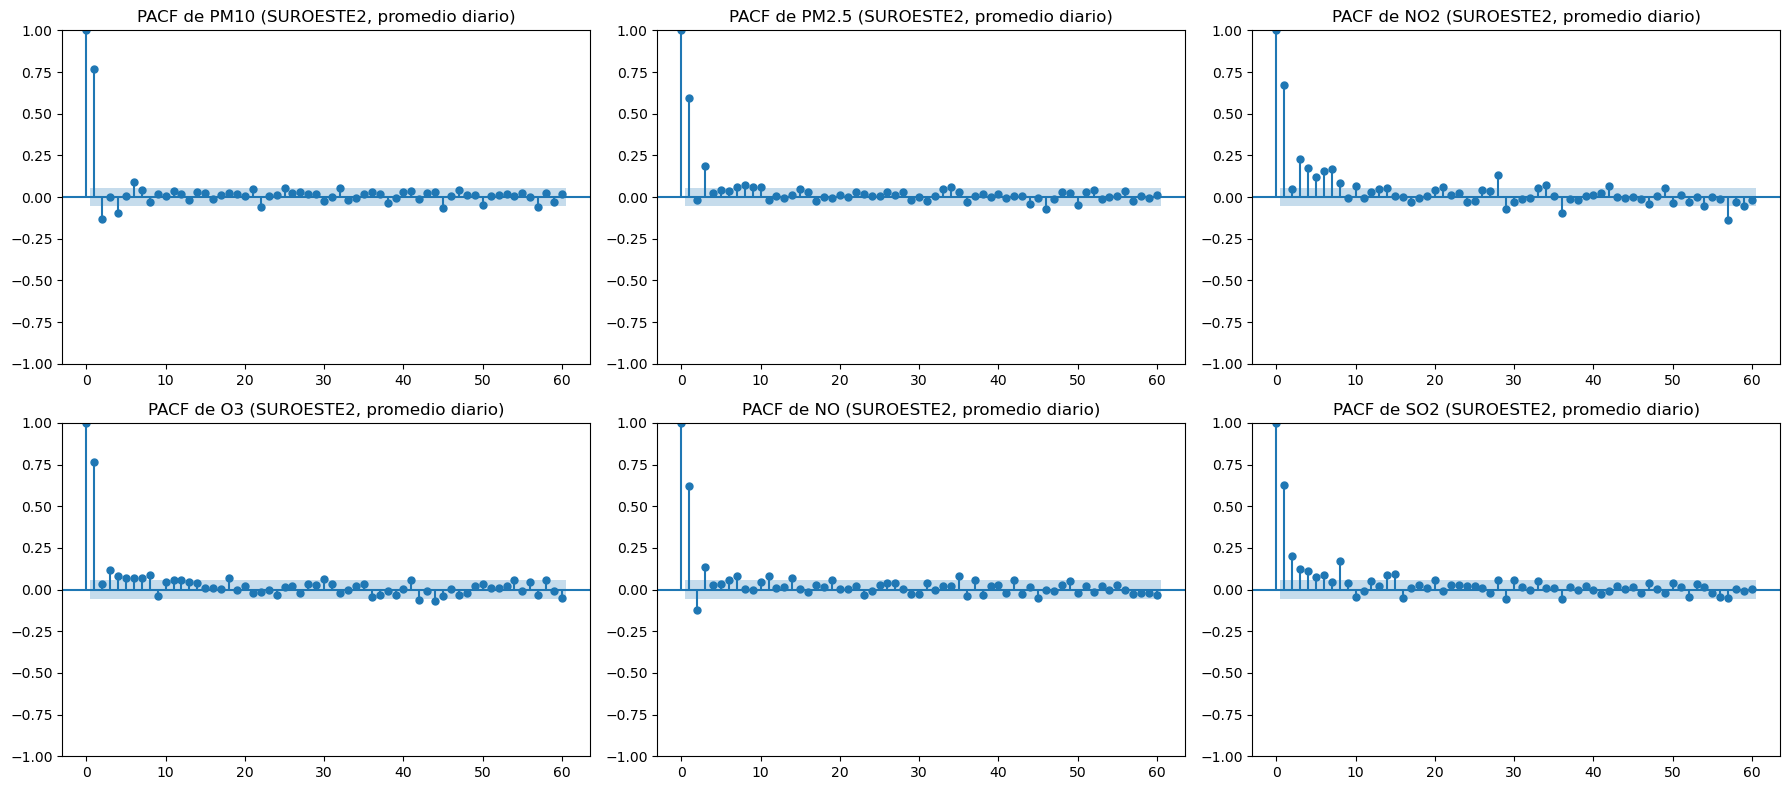

In [30]:
variables_analizar = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]

nrows, ncols = 2, 3  # 3 columnas x 2 filas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_22_25_diario.columns:
        serie = df_22_25_diario[var].dropna()
        plot_pacf(serie, ax=ax, lags=60, alpha=0.05, method='ywm')
        ax.set_title(f"PACF de {var} (SUROESTE2, promedio diario)")
    else:
        ax.set_visible(False)

# Ocultar ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

#### Modelo

In [ ]:
# --- Configuración Inicial ---
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import os

contaminantes_lista = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]
meteo_cols = ["TOUT", "RH", "SR", "PRS"]

# Rangos para buscar el mejor modelo (Grid Search)
p_vals = [1, 2, 3] 
q_vals = [1, 2, 3]
d = 1
c = 1e-3  # Constante para evitar log(0)

resultados_finales = []
summary_dict = {}
graficas_path = "SUROESTE2_arimax_graficas"
os.makedirs(graficas_path, exist_ok=True)

resumen_lines = []
summary_lines = []

resumen_lines.append('Iniciando búsqueda de modelos ARIMAX para todos los contaminantes...\n')

for var in contaminantes_lista:
    if var not in df_22_25_diario.columns:
        mensaje = f"⚠️ Variable {var} no encontrada. Saltando..."
        resumen_lines.append(mensaje)
        continue
        
    mensaje = f"🔄 Procesando: {var}"
    resumen_lines.append(mensaje)
    
    # 1. Preparar datos (filtro y dropna)
    cols_necesarias = [var] + meteo_cols
    df_temp = df_22_25_diario[cols_necesarias].dropna()
    
    if df_temp.empty:
        mensaje = f"   Sin datos suficientes para {var}."
        resumen_lines.append(mensaje)
        continue
        
    # 2. Definir variables Endógena (y) y Exógenas (X)
    y_raw = df_temp[var]
    X = df_temp[meteo_cols]
    
    # Transformación Logarítmica
    y = np.log(y_raw + c)
    
    # Variables para guardar el mejor de este ciclo
    best_aic = np.inf
    best_order = None
    best_res = None
    
    # 3. Loop de Grid Search (p, q)
    for p in p_vals:
        for q in q_vals:
            try:
                model = ARIMA(y, exog=X, order=(p, d, q))
                res = model.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_res = res
                    best_order = (p, d, q)
            except Exception:
                continue
    
    # 4. Guardar el ganador en la lista de resultados y la summary
    if best_res is not None:
        y_pred_log = best_res.fittedvalues
        y_pred_real = np.exp(y_pred_log) - c
        y_raw_alineado = y_raw.loc[y_pred_real.index]
        
        try:
            mape = mean_absolute_percentage_error(y_raw_alineado, y_pred_real)
        except Exception:
            mape = np.nan
        try:
            cme = mean_squared_error(y_raw_alineado, y_pred_real)
            rmse = np.sqrt(cme)
        except Exception:
            cme, rmse = np.nan, np.nan
        
        resultados_finales.append({
            "Variable": var,
            "Mejor_p": best_order[0],
            "Mejor_d": best_order[1],
            "Mejor_q": best_order[2],
            "AIC": best_aic,
            "BIC": best_res.bic,
            "Var_Residuos": np.var(best_res.resid),
            "MAPE": mape,
            "CME": cme,
            "RMSE": rmse
        })
        resumen_txt = (
            f"   ✅ Ganador {var}: ARIMA{best_order} | "
            f"AIC: {best_aic:.2f} | MAPE: {mape:.3%} | CME: {cme:.3f}\n"
        )
        resumen_lines.append(resumen_txt)
        
        summary_txt = f"\n--- Modelo {var} ---\n\n{best_res.summary()}\n"
        summary_lines.append(summary_txt)
        
        # Guardar la gráfica en vez de mostrarla
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        y.plot(ax=ax[0], label='Observado (log)', color='blue')
        y_pred_log.plot(ax=ax[0], label='Ajuste ARIMAX (log)', color='red', alpha=0.7)
        ax[0].set_title(f"{var} (log) Observado vs Ajustado")
        ax[0].legend()

        y_raw.plot(ax=ax[1], label='Observado', color='blue')
        y_pred_real.plot(ax=ax[1], label='Ajuste ARIMAX', color='red', alpha=0.7)
        ax[1].set_title(f"{var} Observado vs Ajustado (escala original)")
        ax[1].legend()
        plt.tight_layout()
        figpath = os.path.join(graficas_path, f"arimax_{var}.png")
        plt.savefig(figpath)
        plt.close(fig)
        
    else:
        msg_no_conv = f"   ❌ No se encontró convergencia para {var}"
        resumen_lines.append(msg_no_conv)

resumen_lines.append("\n--- PROCESO TERMINADO ---")

# Mostrar DataFrame final
df_resultados_arimax_todos = pd.DataFrame(resultados_finales)

if not df_resultados_arimax_todos.empty:
    resumen_lines.append('\nResumen de métricas seleccionadas:\n')
    resumen_lines.append(df_resultados_arimax_todos.to_string(index=False))
else:
    resumen_lines.append("No hubo resultados para mostrar.")

# Guardar todo en un archivo .txt para descarga
salida_txt = "\n".join(resumen_lines)
summary_txt_total = "\n".join(summary_lines)
with open("SUROESTE2_resumen_arimax_resultados.txt", "w", encoding="utf-8") as f:
    f.write(salida_txt)
    f.write('\n\n')
    f.write(summary_txt_total)

# Guardar DataFrame en Excel para descarga
df_resultados_arimax_todos.to_excel("SUROESTE2_resumen_arimax_resultados.xlsx", index=False)

# Instrucción para el usuario (no imprimir nada aquí)
# Los resultados y resúmenes están guardados en:
# - resumen_arimax_resultados.txt
# - resumen_arimax_resultados.xlsx
# - Carpeta 'arimax_graficas/' con las imágenes de los ajustes


## Industrial

### SURESTE3

In [30]:
df_22_25_diario = df_SURESTE3_22_25.copy()
df_22_25_diario.index = pd.to_datetime(df_22_25_diario.index)
df_22_25_diario = df_22_25_diario.resample("D").mean()
df_22_25_diario.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,1277.0,1.354041,0.734329,0.000000,0.886667,1.321667,1.623750,9.153333
NO,1277.0,9.838524,12.180881,1.641667,3.533333,4.966667,10.154167,101.845833
NO2,1277.0,11.170382,6.652305,2.604167,6.166667,9.258333,14.695833,39.945833
O3,1277.0,26.365234,8.036027,4.937500,21.208333,25.541667,30.791667,61.020833
PM10,1277.0,68.326988,34.673176,15.583333,44.500000,59.791667,83.272727,264.291667
PM2.5,1277.0,20.487509,13.245854,3.937500,11.708333,17.000000,25.375000,150.041667
PRS,1277.0,728.318523,5.775650,701.512500,723.204167,728.820833,732.104167,748.125000
RH,1277.0,59.676421,14.756484,13.000000,50.291667,59.958333,69.416667,92.666667
SO2,1277.0,6.721953,4.697142,2.020833,3.991667,5.387500,7.870833,58.695833
SR,1277.0,0.148279,0.062856,0.000000,0.102500,0.153750,0.196667,0.295000


#### ACF

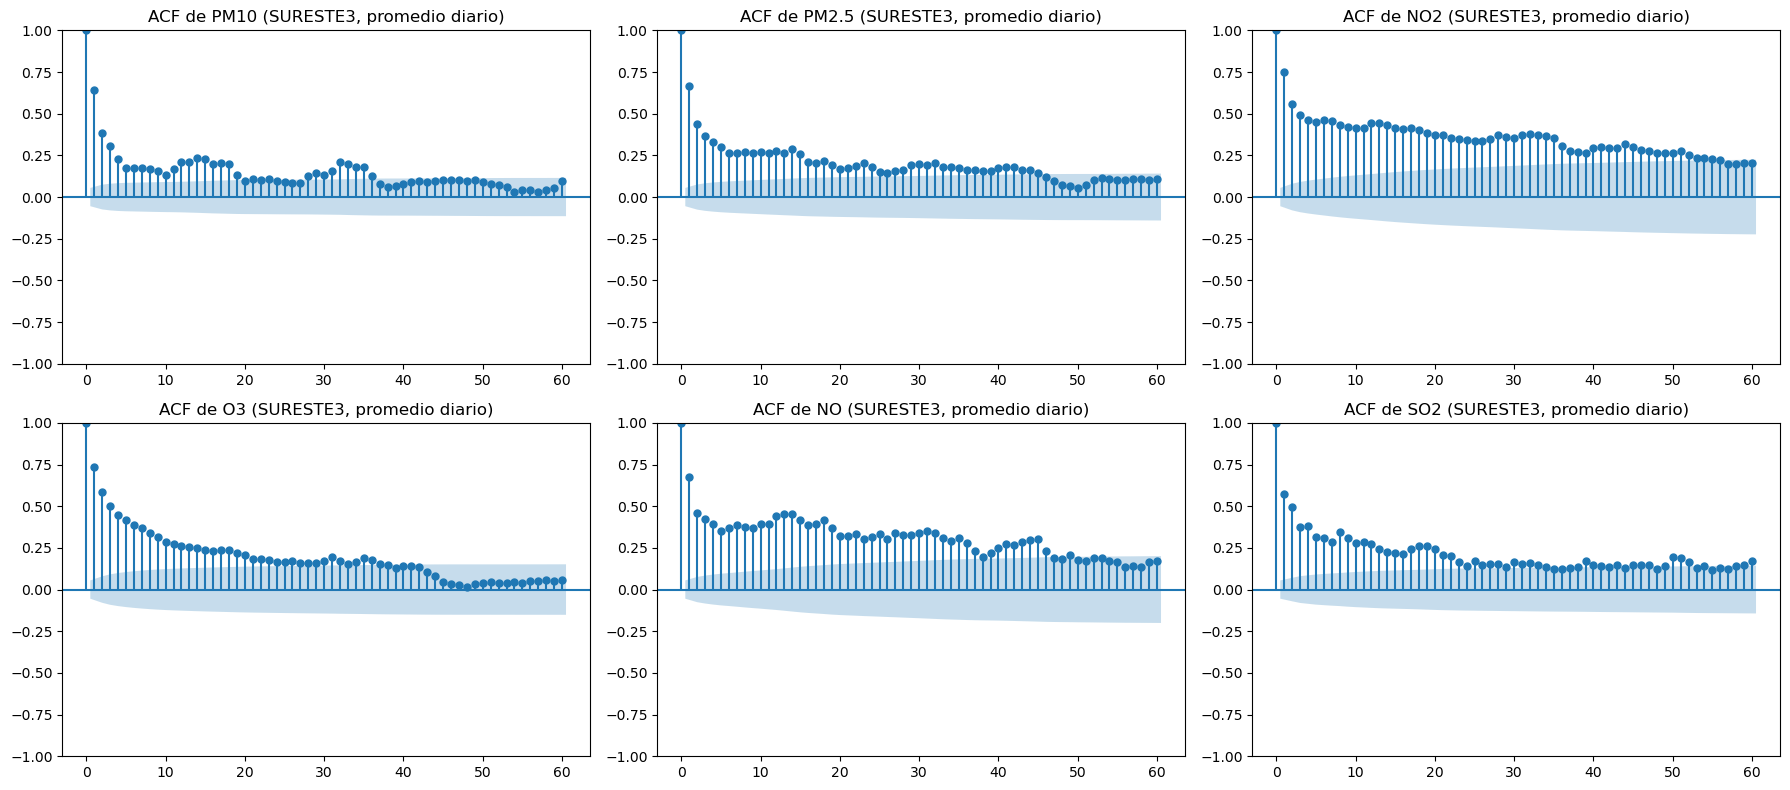

In [31]:
variables_analizar = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]

nrows, ncols = 2, 3  # 3 filas x 2 columnas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()  

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_22_25_diario.columns:
        serie = df_22_25_diario[var].dropna()
        plot_acf(serie, ax=ax, lags=60, alpha=0.05)
        ax.set_title(f"ACF de {var} (SURESTE3, promedio diario)")
    else:
        ax.set_visible(False)

# Oculta ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


#### PACF

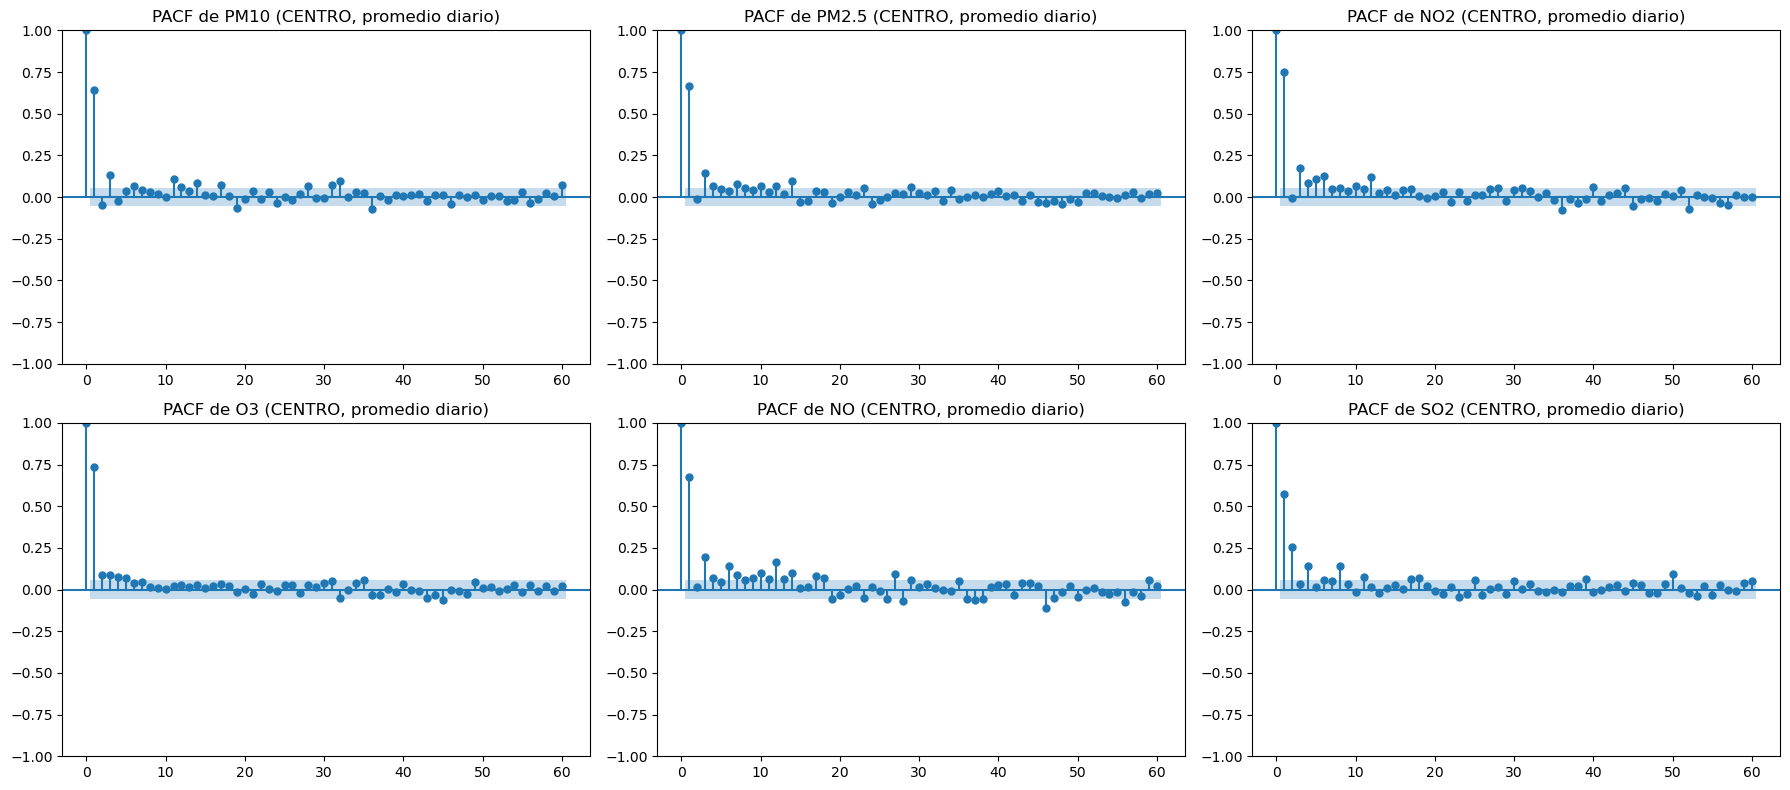

In [32]:
variables_analizar = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]

nrows, ncols = 2, 3  # 3 columnas x 2 filas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_22_25_diario.columns:
        serie = df_22_25_diario[var].dropna()
        plot_pacf(serie, ax=ax, lags=60, alpha=0.05, method='ywm')
        ax.set_title(f"PACF de {var} (CENTRO, promedio diario)")
    else:
        ax.set_visible(False)

# Ocultar ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


#### Modelo

In [ ]:
# --- Configuración Inicial ---

contaminantes_lista = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]
meteo_cols = ["TOUT", "RH", "SR", "PRS"]

# Rangos para buscar el mejor modelo (Grid Search)
p_vals = [1, 2, 3] 
q_vals = [1, 2, 3]
d = 1
c = 1e-3  # Constante para evitar log(0)

resultados_finales = []
summary_dict = {}
graficas_path = "SURESTE3_arimax_graficas"
os.makedirs(graficas_path, exist_ok=True)

resumen_lines = []
summary_lines = []

resumen_lines.append('Iniciando búsqueda de modelos ARIMAX para todos los contaminantes...\n')

for var in contaminantes_lista:
    if var not in df_22_25_diario.columns:
        mensaje = f"⚠️ Variable {var} no encontrada. Saltando..."
        resumen_lines.append(mensaje)
        continue
        
    mensaje = f"🔄 Procesando: {var}"
    resumen_lines.append(mensaje)
    
    # 1. Preparar datos (filtro y dropna)
    cols_necesarias = [var] + meteo_cols
    df_temp = df_22_25_diario[cols_necesarias].dropna()
    
    if df_temp.empty:
        mensaje = f"   Sin datos suficientes para {var}."
        resumen_lines.append(mensaje)
        continue
        
    # 2. Definir variables Endógena (y) y Exógenas (X)
    y_raw = df_temp[var]
    X = df_temp[meteo_cols]
    
    # Transformación Logarítmica
    y = np.log(y_raw + c)
    
    # Variables para guardar el mejor de este ciclo
    best_aic = np.inf
    best_order = None
    best_res = None
    
    # 3. Loop de Grid Search (p, q)
    for p in p_vals:
        for q in q_vals:
            try:
                model = ARIMA(y, exog=X, order=(p, d, q))
                res = model.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_res = res
                    best_order = (p, d, q)
            except Exception:
                continue
    
    # 4. Guardar el ganador en la lista de resultados y la summary
    if best_res is not None:
        y_pred_log = best_res.fittedvalues
        y_pred_real = np.exp(y_pred_log) - c
        y_raw_alineado = y_raw.loc[y_pred_real.index]
        
        try:
            mape = mean_absolute_percentage_error(y_raw_alineado, y_pred_real)
        except Exception:
            mape = np.nan
        try:
            cme = mean_squared_error(y_raw_alineado, y_pred_real)
            rmse = np.sqrt(cme)
        except Exception:
            cme, rmse = np.nan, np.nan
        
        resultados_finales.append({
            "Variable": var,
            "Mejor_p": best_order[0],
            "Mejor_d": best_order[1],
            "Mejor_q": best_order[2],
            "AIC": best_aic,
            "BIC": best_res.bic,
            "Var_Residuos": np.var(best_res.resid),
            "MAPE": mape,
            "CME": cme,
            "RMSE": rmse
        })
        resumen_txt = (
            f"   ✅ Ganador {var}: ARIMA{best_order} | "
            f"AIC: {best_aic:.2f} | MAPE: {mape:.3%} | CME: {cme:.3f}\n"
        )
        resumen_lines.append(resumen_txt)
        
        summary_txt = f"\n--- Modelo {var} ---\n\n{best_res.summary()}\n"
        summary_lines.append(summary_txt)
        
        # Guardar la gráfica en vez de mostrarla
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        y.plot(ax=ax[0], label='Observado (log)', color='blue')
        y_pred_log.plot(ax=ax[0], label='Ajuste ARIMAX (log)', color='red', alpha=0.7)
        ax[0].set_title(f"{var} (log) Observado vs Ajustado")
        ax[0].legend()

        y_raw.plot(ax=ax[1], label='Observado', color='blue')
        y_pred_real.plot(ax=ax[1], label='Ajuste ARIMAX', color='red', alpha=0.7)
        ax[1].set_title(f"{var} Observado vs Ajustado (escala original)")
        ax[1].legend()
        plt.tight_layout()
        figpath = os.path.join(graficas_path, f"arimax_{var}.png")
        plt.savefig(figpath)
        plt.close(fig)
        
    else:
        msg_no_conv = f"   ❌ No se encontró convergencia para {var}"
        resumen_lines.append(msg_no_conv)

resumen_lines.append("\n--- PROCESO TERMINADO ---")

# Mostrar DataFrame final
df_resultados_arimax_todos = pd.DataFrame(resultados_finales)

if not df_resultados_arimax_todos.empty:
    resumen_lines.append('\nResumen de métricas seleccionadas:\n')
    resumen_lines.append(df_resultados_arimax_todos.to_string(index=False))
else:
    resumen_lines.append("No hubo resultados para mostrar.")

# Guardar todo en un archivo .txt para descarga
salida_txt = "\n".join(resumen_lines)
summary_txt_total = "\n".join(summary_lines)
with open("SURESTE3_resumen_arimax_resultados.txt", "w", encoding="utf-8") as f:
    f.write(salida_txt)
    f.write('\n\n')
    f.write(summary_txt_total)

# Guardar DataFrame en Excel para descarga
df_resultados_arimax_todos.to_excel("SURESTE3_resumen_arimax_resultados.xlsx", index=False)


### NORTE 2

In [40]:
df_22_25_diario = df_NORTE2_22_25.copy()
df_22_25_diario.index = pd.to_datetime(df_22_25_diario.index)
df_22_25_diario = df_22_25_diario.resample("D").mean()
df_22_25_diario.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,1277.0,1.126756,0.462281,0.005833,0.872917,1.042083,1.342917,3.180000
NO,1277.0,22.007082,16.742832,2.737500,10.079167,16.425000,28.329167,130.645833
NO2,1277.0,24.707027,10.140976,5.687500,16.529167,22.895833,30.783333,68.387500
O3,1277.0,24.375347,8.588382,2.208333,18.666667,23.791667,29.333333,56.625000
PM10,1277.0,66.579798,31.321534,9.208333,45.625000,60.541667,80.375000,291.625000
PM2.5,1277.0,20.140836,9.347812,2.791667,13.500000,18.500000,25.041667,99.833333
PRS,1277.0,712.720229,3.818074,695.479167,710.233333,712.379167,714.870833,726.095833
RH,1277.0,54.544782,15.465329,8.958333,45.375000,55.000000,64.291667,90.000000
SO2,1277.0,4.644225,1.613734,1.954167,3.512500,4.275000,5.522917,16.927083
SR,1277.0,0.123256,0.050743,0.007500,0.093333,0.128333,0.165000,0.213750


#### ACF

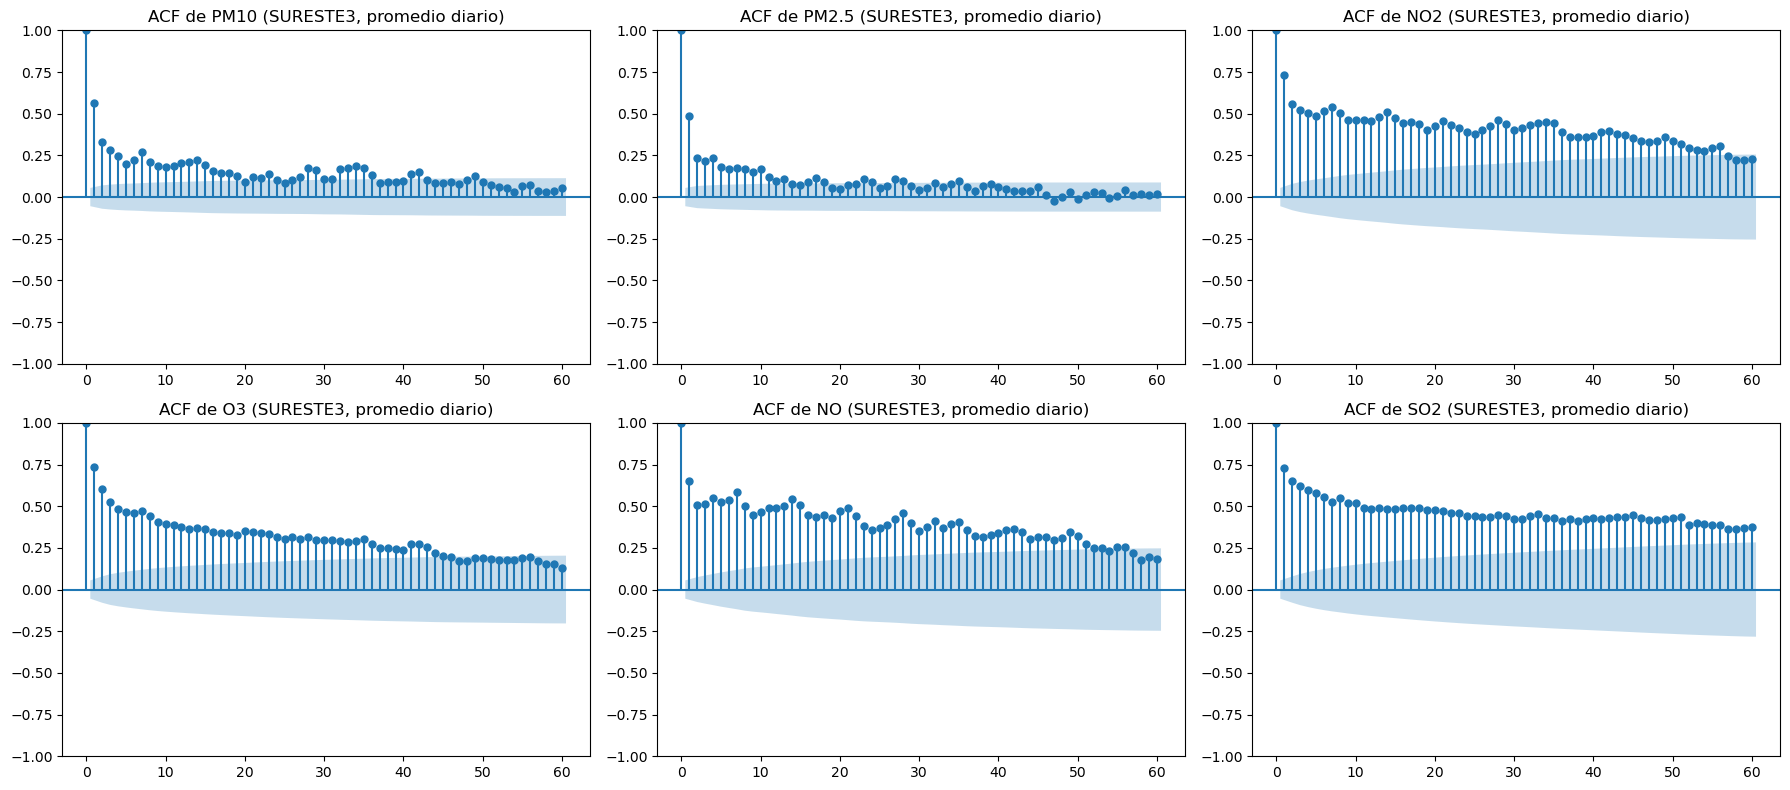

In [41]:
variables_analizar = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]

nrows, ncols = 2, 3  # 3 filas x 2 columnas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()  

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_22_25_diario.columns:
        serie = df_22_25_diario[var].dropna()
        plot_acf(serie, ax=ax, lags=60, alpha=0.05)
        ax.set_title(f"ACF de {var} (SURESTE3, promedio diario)")
    else:
        ax.set_visible(False)

# Oculta ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


#### PACF

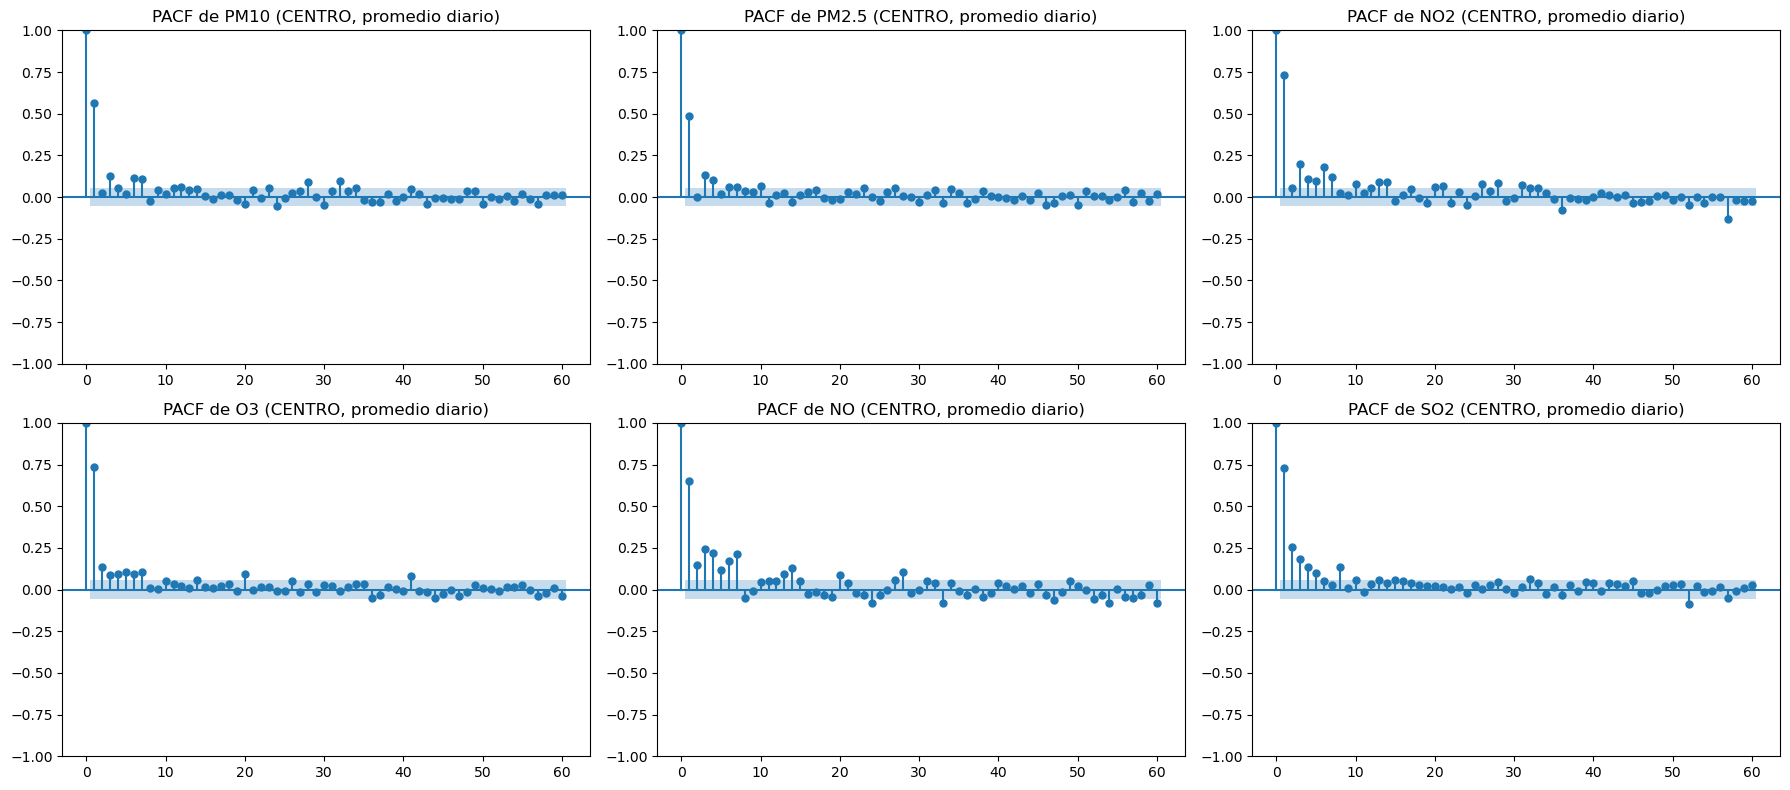

In [42]:
variables_analizar = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]

nrows, ncols = 2, 3  # 3 columnas x 2 filas
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 8))
axes = axes.flatten()

for i, var in enumerate(variables_analizar):
    ax = axes[i]
    if var in df_22_25_diario.columns:
        serie = df_22_25_diario[var].dropna()
        plot_pacf(serie, ax=ax, lags=60, alpha=0.05, method='ywm')
        ax.set_title(f"PACF de {var} (CENTRO, promedio diario)")
    else:
        ax.set_visible(False)

# Ocultar ejes extra si hay menos variables
for j in range(len(variables_analizar), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

#### Modelo

In [ ]:
# --- Configuración Inicial ---
contaminantes_lista = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]
meteo_cols = ["TOUT", "RH", "SR", "PRS"]

# Rangos para buscar el mejor modelo (Grid Search)
p_vals = [1, 2, 3] 
q_vals = [1, 2, 3]
d = 1
c = 1e-3  # Constante para evitar log(0)

resultados_finales = []
summary_dict = {}
graficas_path = "NORTE2_arimax_graficas"
os.makedirs(graficas_path, exist_ok=True)

resumen_lines = []
summary_lines = []

resumen_lines.append('Iniciando búsqueda de modelos ARIMAX para todos los contaminantes...\n')

for var in contaminantes_lista:
    if var not in df_22_25_diario.columns:
        mensaje = f"⚠️ Variable {var} no encontrada. Saltando..."
        resumen_lines.append(mensaje)
        continue
        
    mensaje = f"🔄 Procesando: {var}"
    resumen_lines.append(mensaje)
    
    # 1. Preparar datos (filtro y dropna)
    cols_necesarias = [var] + meteo_cols
    df_temp = df_22_25_diario[cols_necesarias].dropna()
    
    if df_temp.empty:
        mensaje = f"   Sin datos suficientes para {var}."
        resumen_lines.append(mensaje)
        continue
        
    # 2. Definir variables Endógena (y) y Exógenas (X)
    y_raw = df_temp[var]
    X = df_temp[meteo_cols]
    
    # Transformación Logarítmica
    y = np.log(y_raw + c)
    
    # Variables para guardar el mejor de este ciclo
    best_aic = np.inf
    best_order = None
    best_res = None
    
    # 3. Loop de Grid Search (p, q)
    for p in p_vals:
        for q in q_vals:
            try:
                model = ARIMA(y, exog=X, order=(p, d, q))
                res = model.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_res = res
                    best_order = (p, d, q)
            except Exception:
                continue
    
    # 4. Guardar el ganador en la lista de resultados y la summary
    if best_res is not None:
        y_pred_log = best_res.fittedvalues
        y_pred_real = np.exp(y_pred_log) - c
        y_raw_alineado = y_raw.loc[y_pred_real.index]
        
        try:
            mape = mean_absolute_percentage_error(y_raw_alineado, y_pred_real)
        except Exception:
            mape = np.nan
        try:
            cme = mean_squared_error(y_raw_alineado, y_pred_real)
            rmse = np.sqrt(cme)
        except Exception:
            cme, rmse = np.nan, np.nan
        
        resultados_finales.append({
            "Variable": var,
            "Mejor_p": best_order[0],
            "Mejor_d": best_order[1],
            "Mejor_q": best_order[2],
            "AIC": best_aic,
            "BIC": best_res.bic,
            "Var_Residuos": np.var(best_res.resid),
            "MAPE": mape,
            "CME": cme,
            "RMSE": rmse
        })
        resumen_txt = (
            f"   ✅ Ganador {var}: ARIMA{best_order} | "
            f"AIC: {best_aic:.2f} | MAPE: {mape:.3%} | CME: {cme:.3f}\n"
        )
        resumen_lines.append(resumen_txt)
        
        summary_txt = f"\n--- Modelo {var} ---\n\n{best_res.summary()}\n"
        summary_lines.append(summary_txt)
        
        # Guardar la gráfica en vez de mostrarla
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        y.plot(ax=ax[0], label='Observado (log)', color='blue')
        y_pred_log.plot(ax=ax[0], label='Ajuste ARIMAX (log)', color='red', alpha=0.7)
        ax[0].set_title(f"{var} (log) Observado vs Ajustado")
        ax[0].legend()

        y_raw.plot(ax=ax[1], label='Observado', color='blue')
        y_pred_real.plot(ax=ax[1], label='Ajuste ARIMAX', color='red', alpha=0.7)
        ax[1].set_title(f"{var} Observado vs Ajustado (escala original)")
        ax[1].legend()
        plt.tight_layout()
        figpath = os.path.join(graficas_path, f"arimax_{var}.png")
        plt.savefig(figpath)
        plt.close(fig)
        
    else:
        msg_no_conv = f"   ❌ No se encontró convergencia para {var}"
        resumen_lines.append(msg_no_conv)

resumen_lines.append("\n--- PROCESO TERMINADO ---")

# Mostrar DataFrame final
df_resultados_arimax_todos = pd.DataFrame(resultados_finales)

if not df_resultados_arimax_todos.empty:
    resumen_lines.append('\nResumen de métricas seleccionadas:\n')
    resumen_lines.append(df_resultados_arimax_todos.to_string(index=False))
else:
    resumen_lines.append("No hubo resultados para mostrar.")

# Guardar todo en un archivo .txt para descarga
salida_txt = "\n".join(resumen_lines)
summary_txt_total = "\n".join(summary_lines)
with open("NORTE2_resumen_arimax_resultados.txt", "w", encoding="utf-8") as f:
    f.write(salida_txt)
    f.write('\n\n')
    f.write(summary_txt_total)

# Guardar DataFrame en Excel para descarga
df_resultados_arimax_todos.to_excel("NORTE2_resumen_arimax_resultados.xlsx", index=False)


# Análisis

## Comparaciones

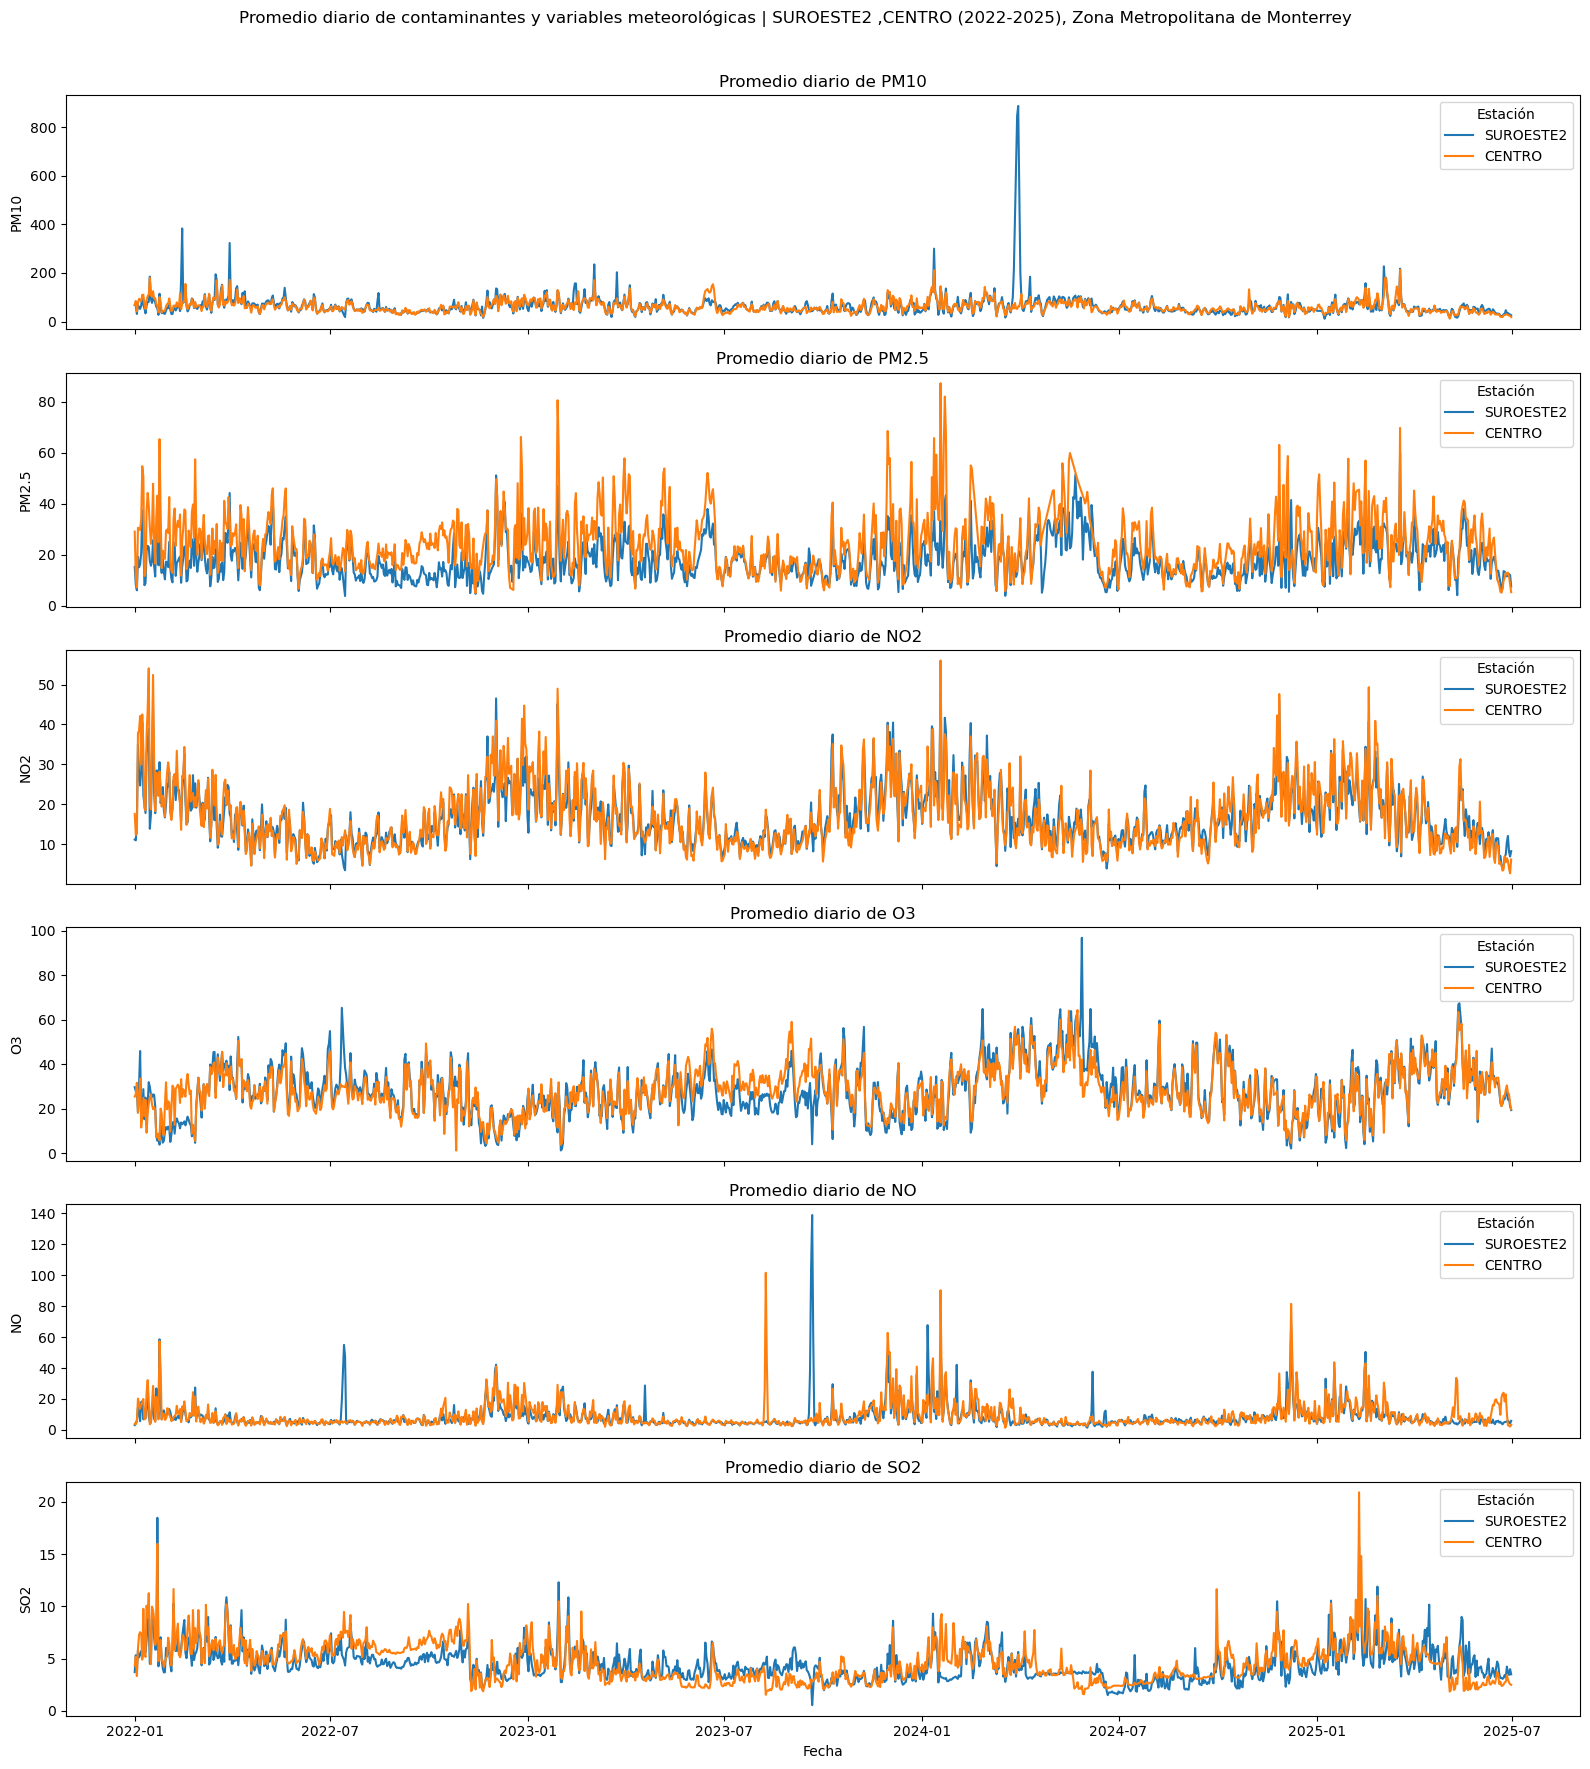

In [50]:

contaminantes = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]
#meteo = ["TOUT", "RH", "SR", "PRS"]
vars_plot = contaminantes # + meteo
estaciones1 = ["SUROESTE2", "CENTRO"]

# Crear un DataFrame resumen para todos los contaminantes y meteorológicos por estación, por día
# Cada columna será "estacion_variable", filas por fecha. Así permite graficar todo junto.
df_all = None
for estacion in estaciones1:
    df_est = df_22_25_by_station[estacion].copy()
    df_est.index = pd.to_datetime(df_est.index)
    dfd = df_est[ [col for col in df_est.columns if col.upper() in [v.upper() for v in vars_plot]] ].resample("D").mean()
    dfd.columns = [f"{estacion}_{col}" for col in dfd.columns]
    df_all = dfd if df_all is None else pd.concat([df_all, dfd], axis=1)

# Graficar en una sola hoja, 1 fila por variable (contaminantes y meteorológicos)
nrows = len(vars_plot)
fig, axes = plt.subplots(nrows, 1, figsize=(16, 3 * nrows), sharex=True)

for i, var in enumerate(vars_plot):
    ax = axes[i] if nrows > 1 else axes
    for estacion in estaciones1:
        colname = f"{estacion}_{var}"
        if colname in df_all.columns:
            ax.plot(df_all.index, df_all[colname], label=estacion)
    ax.set_ylabel(f"{var}")
    ax.legend(title="Estación")
    ax.set_title(f"Promedio diario de {var}")

axes[-1].set_xlabel("Fecha")
plt.suptitle(f"Promedio diario de contaminantes y variables meteorológicas | {' ,'.join(estaciones1)} (2022-2025), Zona Metropolitana de Monterrey")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()




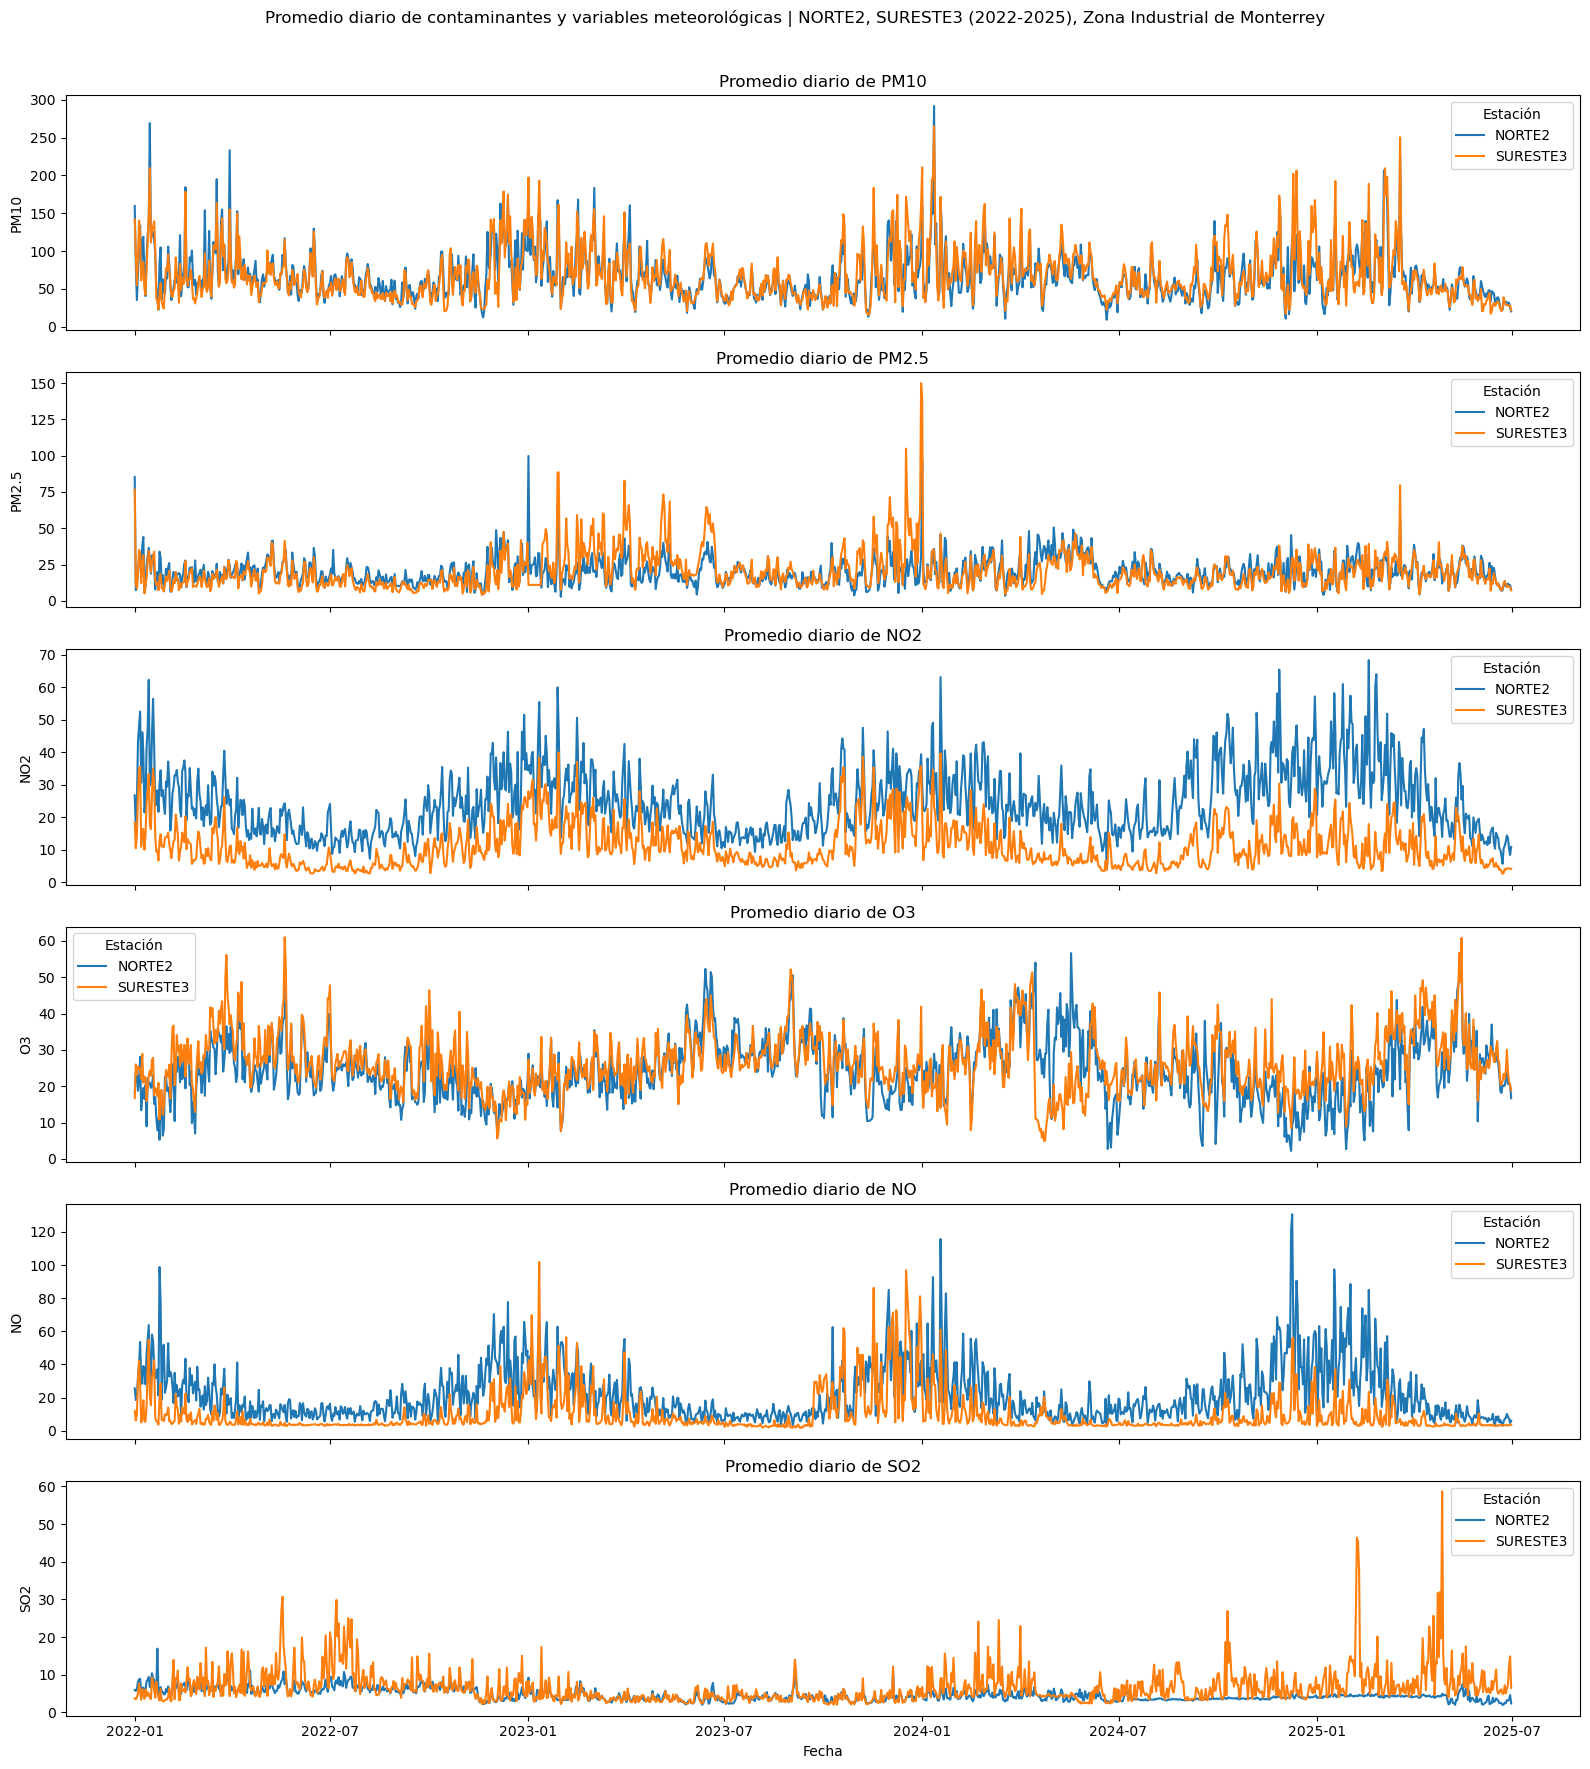

In [51]:

contaminantes = ["PM10", "PM2.5", "NO2", "O3", "NO", "SO2"]
#meteo = ["TOUT", "RH", "SR", "PRS"]
vars_plot = contaminantes #+ meteo
estaciones1 = ["NORTE2", "SURESTE3"]

# Crear un DataFrame resumen para todos los contaminantes y meteorológicos por estación, por día
# Cada columna será "estacion_variable", filas por fecha. Así permite graficar todo junto.
df_all = None
for estacion in estaciones1:
    df_est = df_22_25_by_station[estacion].copy()
    df_est.index = pd.to_datetime(df_est.index)
    dfd = df_est[ [col for col in df_est.columns if col.upper() in [v.upper() for v in vars_plot]] ].resample("D").mean()
    dfd.columns = [f"{estacion}_{col}" for col in dfd.columns]
    df_all = dfd if df_all is None else pd.concat([df_all, dfd], axis=1)

# Graficar en una sola hoja, 1 fila por variable (contaminantes y meteorológicos)
nrows = len(vars_plot)
fig, axes = plt.subplots(nrows, 1, figsize=(16, 3 * nrows), sharex=True)

for i, var in enumerate(vars_plot):
    ax = axes[i] if nrows > 1 else axes
    for estacion in estaciones1:
        colname = f"{estacion}_{var}"
        if colname in df_all.columns:
            ax.plot(df_all.index, df_all[colname], label=estacion)
    ax.set_ylabel(f"{var}")
    ax.legend(title="Estación")
    ax.set_title(f"Promedio diario de {var}")

axes[-1].set_xlabel("Fecha")
plt.suptitle(f"Promedio diario de contaminantes y variables meteorológicas | {', '.join(estaciones1)} (2022-2025), Zona Industrial de Monterrey")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Análisis - CENTRO

In [52]:
estacion = "CENTRO"
df = df_CENTRO_22_25.copy()
df.index = pd.to_datetime(df.index)

print("Shape:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nRango temporal:", df.index.min(), "→", df.index.max())
df.info()
df.describe().T

Shape: (30646, 11)

Columnas: ['CO', 'NO', 'NO2', 'O3', 'PM10', 'PM2.5', 'PRS', 'RH', 'SO2', 'SR', 'TOUT']

Rango temporal: 2022-01-01 00:00:00 → 2025-06-30 23:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30646 entries, 2022-01-01 00:00:00 to 2025-06-30 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      30646 non-null  float64
 1   NO      30646 non-null  float64
 2   NO2     30646 non-null  float64
 3   O3      30646 non-null  float64
 4   PM10    30646 non-null  float64
 5   PM2.5   30646 non-null  float64
 6   PRS     30646 non-null  float64
 7   RH      30646 non-null  float64
 8   SO2     30646 non-null  float64
 9   SR      30646 non-null  float64
 10  TOUT    30646 non-null  float64
dtypes: float64(11)
memory usage: 2.8 MB


,count,mean,std,min,25%,50%,75%,max
CO,30646.0,1.579748,0.773366,0.05,1.00,1.44,2.08,5.63
NO,30646.0,9.039951,13.351785,0.50,2.60,3.90,9.70,288.40
NO2,30646.0,16.997454,11.214317,0.00,8.30,14.50,22.90,97.90
O3,30646.0,28.350209,20.315991,1.00,12.00,24.00,39.00,166.00
PM10,30646.0,61.026239,34.093114,2.00,39.00,53.00,74.00,735.00
PM2.5,30646.0,24.728120,15.021518,2.00,13.96,21.36,32.08,246.93
PRS,30646.0,711.363277,3.666050,682.40,709.10,711.10,713.50,726.00
RH,30646.0,54.336793,20.809648,1.00,38.00,56.00,71.00,94.00
SO2,30646.0,4.665761,2.732116,0.50,3.00,4.20,5.60,85.80
SR,30646.0,0.183108,0.279082,0.00,0.00,0.01,0.30,1.25


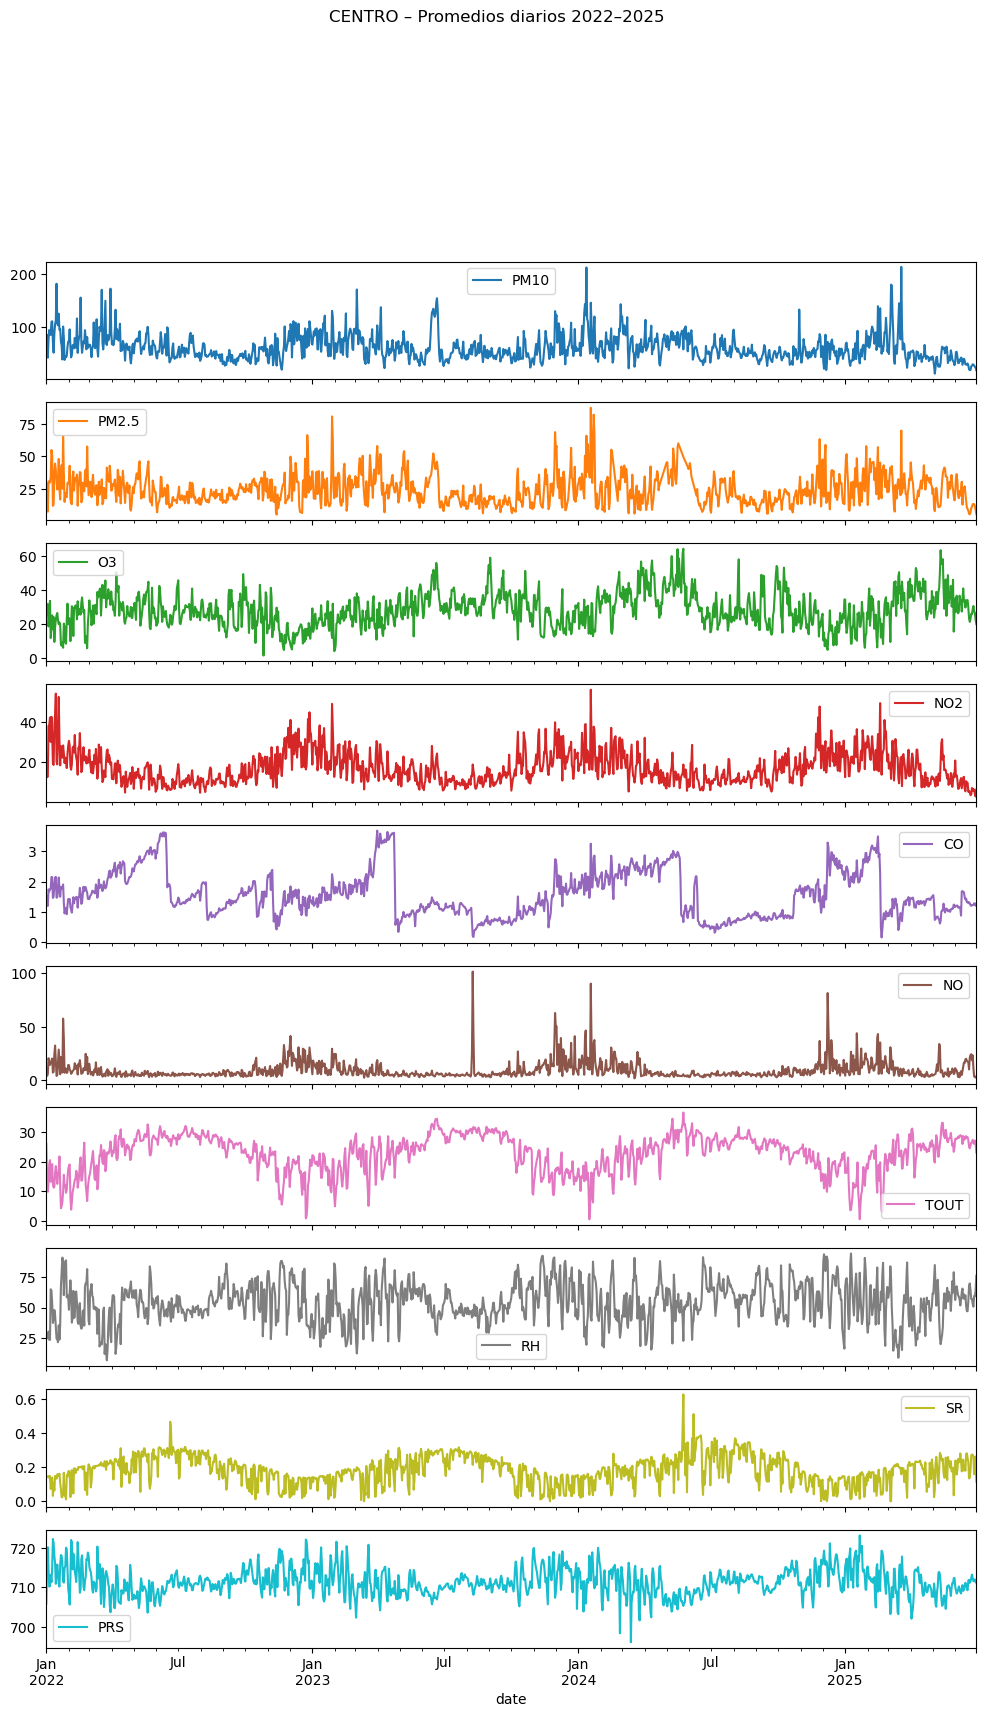

,PM10,PM2.5,O3,NO2,CO,NO,TOUT,RH,SR,PRS
PM10,1.000000,0.613924,0.076726,0.457462,0.269537,0.339802,0.015279,-0.228583,0.231324,-0.147565
PM2.5,0.613924,1.000000,-0.031949,0.494039,0.367352,0.384621,-0.065393,0.072683,0.117888,-0.163233
O3,0.076726,-0.031949,1.000000,-0.295509,-0.088036,-0.297683,0.532095,-0.598938,0.583778,-0.227252
NO2,0.457462,0.494039,-0.295509,1.000000,0.320608,0.528673,-0.332101,0.010195,-0.021683,0.086457
CO,0.269537,0.367352,-0.088036,0.320608,1.000000,0.274172,-0.150365,0.041535,-0.017345,-0.106605
NO,0.339802,0.384621,-0.297683,0.528673,0.274172,1.000000,-0.252687,0.120539,-0.003159,0.077362
TOUT,0.015279,-0.065393,0.532095,-0.332101,-0.150365,-0.252687,1.000000,-0.439681,0.425029,-0.620303
RH,-0.228583,0.072683,-0.598938,0.010195,0.041535,0.120539,-0.439681,1.000000,-0.393316,0.196571
SR,0.231324,0.117888,0.583778,-0.021683,-0.017345,-0.003159,0.425029,-0.393316,1.000000,-0.102105
PRS,-0.147565,-0.163233,-0.227252,0.086457,-0.106605,0.077362,-0.620303,0.196571,-0.102105,1.000000


In [53]:
cols_to_plot = ['PM10', 'PM2.5', 'O3','NO2','CO', 'NO','TOUT','RH','SR','PRS']
df[cols_to_plot].resample("D").mean().plot(subplots=True, figsize=(12, 18), sharex=True)
plt.suptitle(f"{estacion} – Promedios diarios 2022–2025", y=1.02)
plt.show()

# Correlaciones básicas
corr = df.corr()
corr.loc[cols_to_plot, cols_to_plot]

### Matriz de correlación

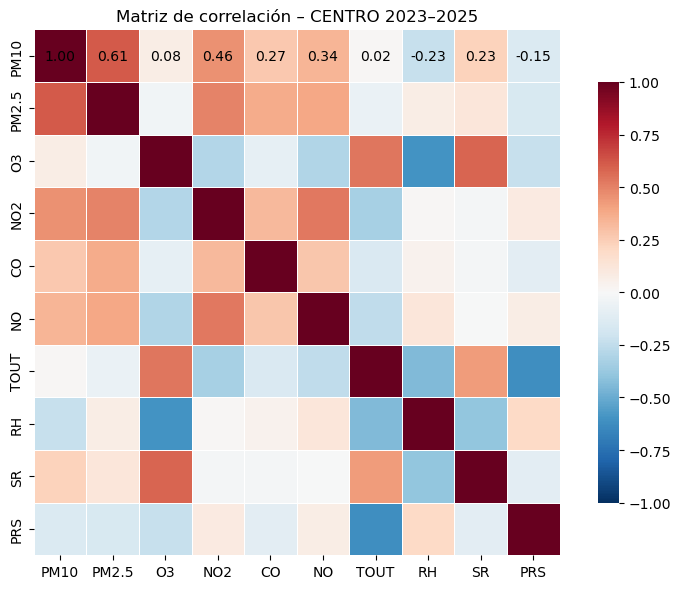

In [54]:
corr_subset = df[cols_to_plot].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_subset,
    annot=True,        
    fmt=".2f",         
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"color": "black", "fontsize": 10}  
)
plt.title("Matriz de correlación – CENTRO 2023–2025")
plt.tight_layout()
plt.show()

### PCA

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Matriz de varianza-covarianza:
 [[ 1.16234e+03  3.14410e+02  5.31400e+01  2.68700e+01  1.74900e+02
   7.11000e+00  3.76000e+00 -1.62170e+02  2.20000e+00 -1.84400e+01]
 [ 3.14410e+02  2.25650e+02 -9.75000e+00  1.02600e+01  8.32200e+01
   4.27000e+00 -7.10000e+00  2.27200e+01  4.90000e-01 -8.99000e+00]
 [ 5.31400e+01 -9.75000e+00  4.12740e+02  4.48000e+00 -6.73300e+01
  -1.38000e+00  7.80800e+01 -2.53210e+02  3.31000e+00 -1.69300e+01]
 [ 2.68700e+01  1.02600e+01  4.48000e+00  7.46000e+00  1.08300e+01
   5.70000e-01 -1.57000e+00 -1.30700e+01  1.20000e-01  6.40000e-01]
 [ 1.74900e+02  8.32200e+01 -6.73300e+01  1.08300e+01  1.25760e+02
   2.78000e+00 -2.69000e+01  2.38000e+00 -7.00000e-02  3.55000e+00]
 [ 7.11000e+00  4.27000e+00 -1.38000e+00  5

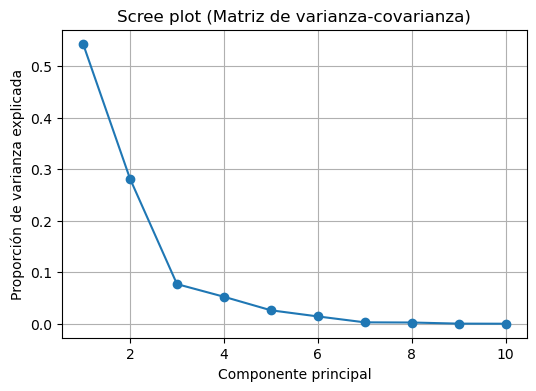

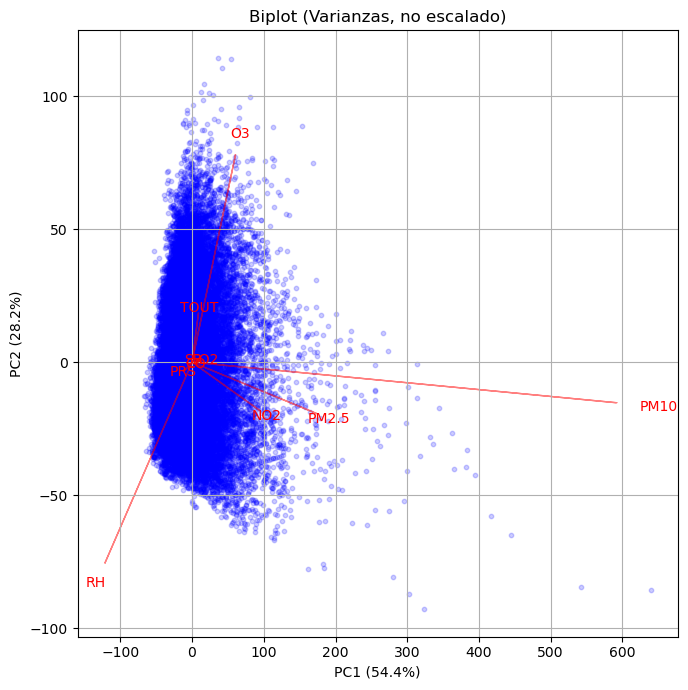

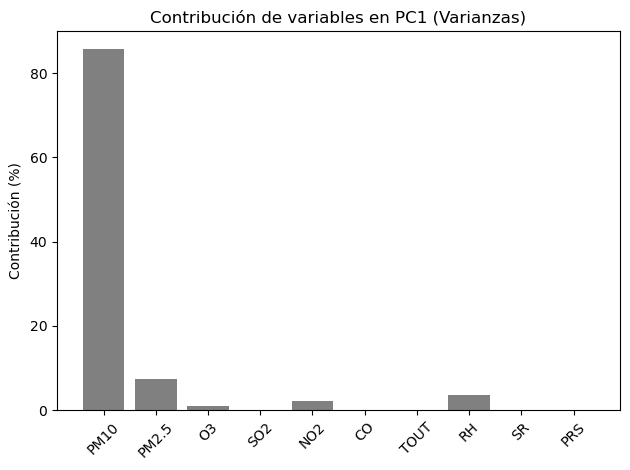

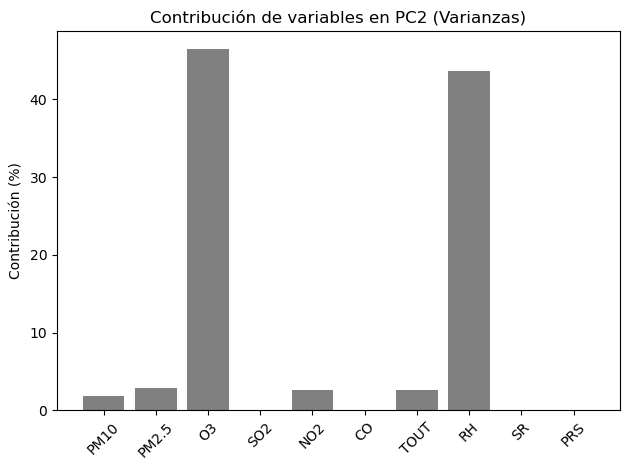

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Matriz de correlación:
 [[ 1.    0.61  0.08  0.29  0.46  0.27  0.02 -0.23  0.23 -0.15]
 [ 0.61  1.   -0.03  0.25  0.49  0.37 -0.07  0.07  0.12 -0.16]
 [ 0.08 -0.03  1.    0.08 -0.3  -0.09  0.53 -0.6   0.58 -0.23]
 [ 0.29  0.25  0.08  1.    0.35  0.27 -0.08 -0.23  0.16  0.06]
 [ 0.46  0.49 -0.3   0.35  1.    0.32 -0.33  0.01 -0.02  0.09]
 [ 0.27  0.37 -0.09  0.27  0.32  1.   -0.15  0.04 -0.02 -0.11]
 [ 0.02 -0.07  0.53 -0.08 -0.33 -0.15  1.   -0.44  0.43 -0.62]
 [-0.23  0.07 -0.6  -0.23  0.01  0.04 -0.44  1.   -0.39  0.2 ]
 [ 0.23  0.12  0.58  0.16 -0.02 -0.02  0.43 -0.39  1.   -0.1 ]
 [-0.15 -0.16 -0.23  0.06  0.09 -0.11 -0.62  0.2  -0.1   1.  ]]


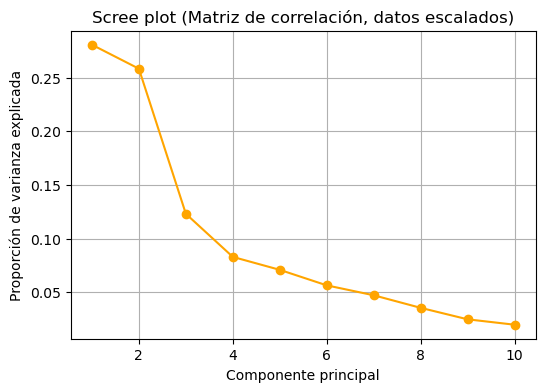

/Users/gabrielvas/anaconda3/envs/tecmx2/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


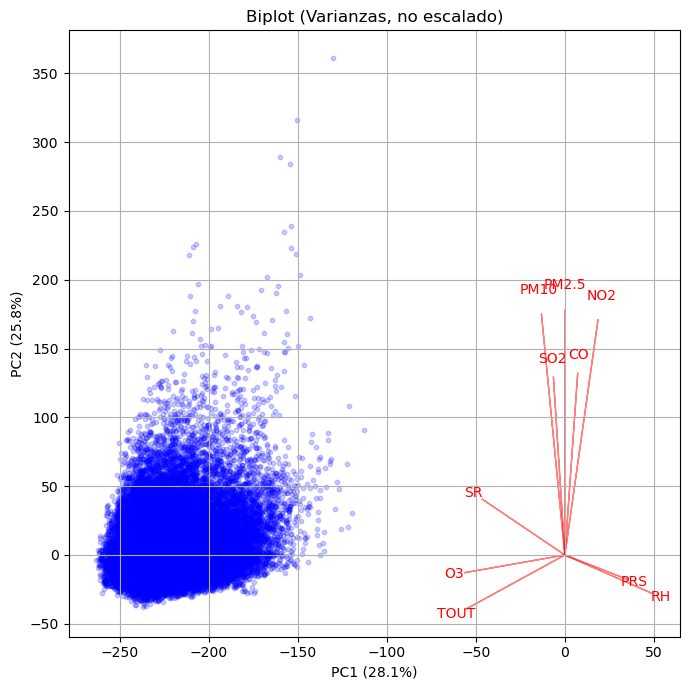

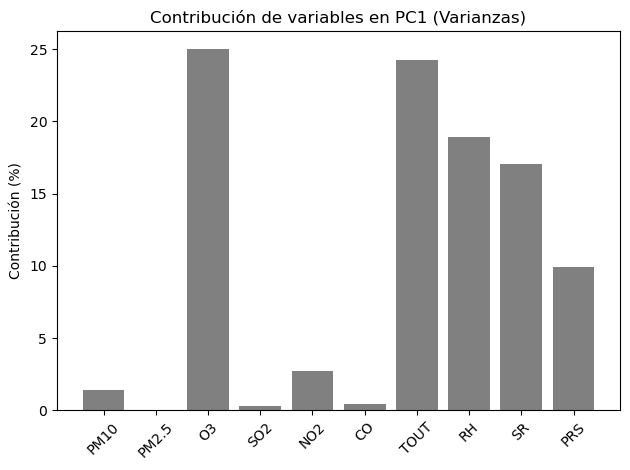

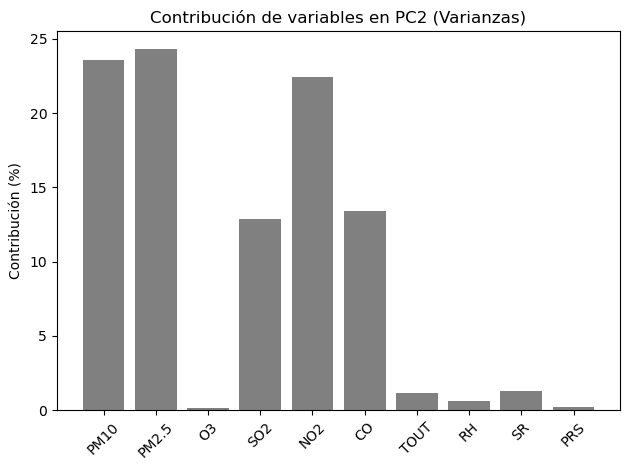

In [55]:
cols_pca = ['PM10', 'PM2.5', 'O3', 'SO2','NO2','CO','TOUT','RH','SR','PRS']

X = df[cols_pca].dropna()

# 1. Matriz de Varianza-Covarianza
cov_matrix = np.cov(X.values, rowvar=False)
print("Matriz de varianza-covarianza:\n", np.round(cov_matrix, 2))

# 2. Valores y vectores propios (autovalores y autovectores)
eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
# Ordenar de mayor a menor
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

print("\nValores propios:\n", np.round(eig_vals, 2))
print("\nVectores propios (columnas):\n", np.round(eig_vecs, 2))

# 3. Proporción de varianza explicada
explained_var_ratio = eig_vals / np.sum(eig_vals)
print("\nProporción de varianza explicada:\n", np.round(explained_var_ratio, 3))

# 4. Varianza acumulada
cumulative_var_ratio = np.cumsum(explained_var_ratio)
print("\nVarianza acumulada por componente:\n", np.round(cumulative_var_ratio, 3))

# 5. Gráficas de PCA (sobre matriz de varianzas/covarianzas, sin escalado)
pca_cov = PCA(n_components=len(cols_pca), svd_solver='full')
pca_cov.fit(X)

# Scree plot (varianza explicada por componente)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cols_pca)+1), pca_cov.explained_variance_ratio_, marker='o')
plt.xlabel('Componente principal')
plt.ylabel('Proporción de varianza explicada')
plt.title('Scree plot (Matriz de varianza-covarianza)')
plt.grid(True)
plt.show()

# Biplot - proyección de los individuos y las variables
def pca_biplot(pca, x_pc=1, y_pc=2, labels=None, color="blue"):
    X_reduced = pca.transform(X)
    fig, ax = plt.subplots(figsize=(7,7))
    ax.scatter(X_reduced[:, x_pc-1], X_reduced[:, y_pc-1], alpha=0.2, color=color, s=10)
    for i, var in enumerate(cols_pca):
        ax.arrow(0, 0, 
                 pca.components_[x_pc-1, i]*max(X_reduced[:, x_pc-1]),
                 pca.components_[y_pc-1, i]*max(X_reduced[:, y_pc-1]),
                 color="red", width=0.002, head_width=0.08, alpha=0.5)
        ax.text(pca.components_[x_pc-1, i]*max(X_reduced[:, x_pc-1])*1.1,
                pca.components_[y_pc-1, i]*max(X_reduced[:, y_pc-1])*1.1,
                var, color='red', ha='center', va='center')
    ax.set_xlabel(f'PC{x_pc} ({pca.explained_variance_ratio_[x_pc-1]*100:.1f}%)')
    ax.set_ylabel(f'PC{y_pc} ({pca.explained_variance_ratio_[y_pc-1]*100:.1f}%)')
    ax.set_title("Biplot (Varianzas, no escalado)")
    plt.grid()
    plt.tight_layout()
    plt.show()

pca_biplot(pca_cov, 1, 2)

# Contribución de cada variable en PC1 y PC2
def plot_var_contrib(pca, pc=1):
    contrib = np.square(pca.components_[pc-1])
    contrib = contrib/np.sum(contrib) * 100  # porcentaje
    plt.bar(cols_pca, contrib, color="gray")
    plt.ylabel('Contribución (%)')
    plt.title(f'Contribución de variables en PC{pc} (Varianzas)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_var_contrib(pca_cov, 1)
plot_var_contrib(pca_cov, 2)

# --- Repetir análisis escalando los datos (matriz de correlación) ---

X_scaled = StandardScaler().fit_transform(X)

# Matriz de correlación
corr_matrix = np.corrcoef(X_scaled, rowvar=False)
print("\nMatriz de correlación:\n", np.round(corr_matrix, 2))

# PCA sobre matriz de correlaciones (datos estándar: media 0, var 1)
pca_corr = PCA(n_components=len(cols_pca))
pca_corr.fit(X_scaled)

# Scree plot (matriz de correlación)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cols_pca)+1), pca_corr.explained_variance_ratio_, marker='o', color="orange")
plt.xlabel('Componente principal')
plt.ylabel('Proporción de varianza explicada')
plt.title('Scree plot (Matriz de correlación, datos escalados)')
plt.grid(True)
plt.show()

# Biplot de PCA (sobre datos estandarizados)
pca_biplot(pca_corr, 1, 2)

# Contribución de variables en PC1 y PC2 (matriz de correlación)
plot_var_contrib(pca_corr, 1)
plot_var_contrib(pca_corr, 2)


### Box Plot

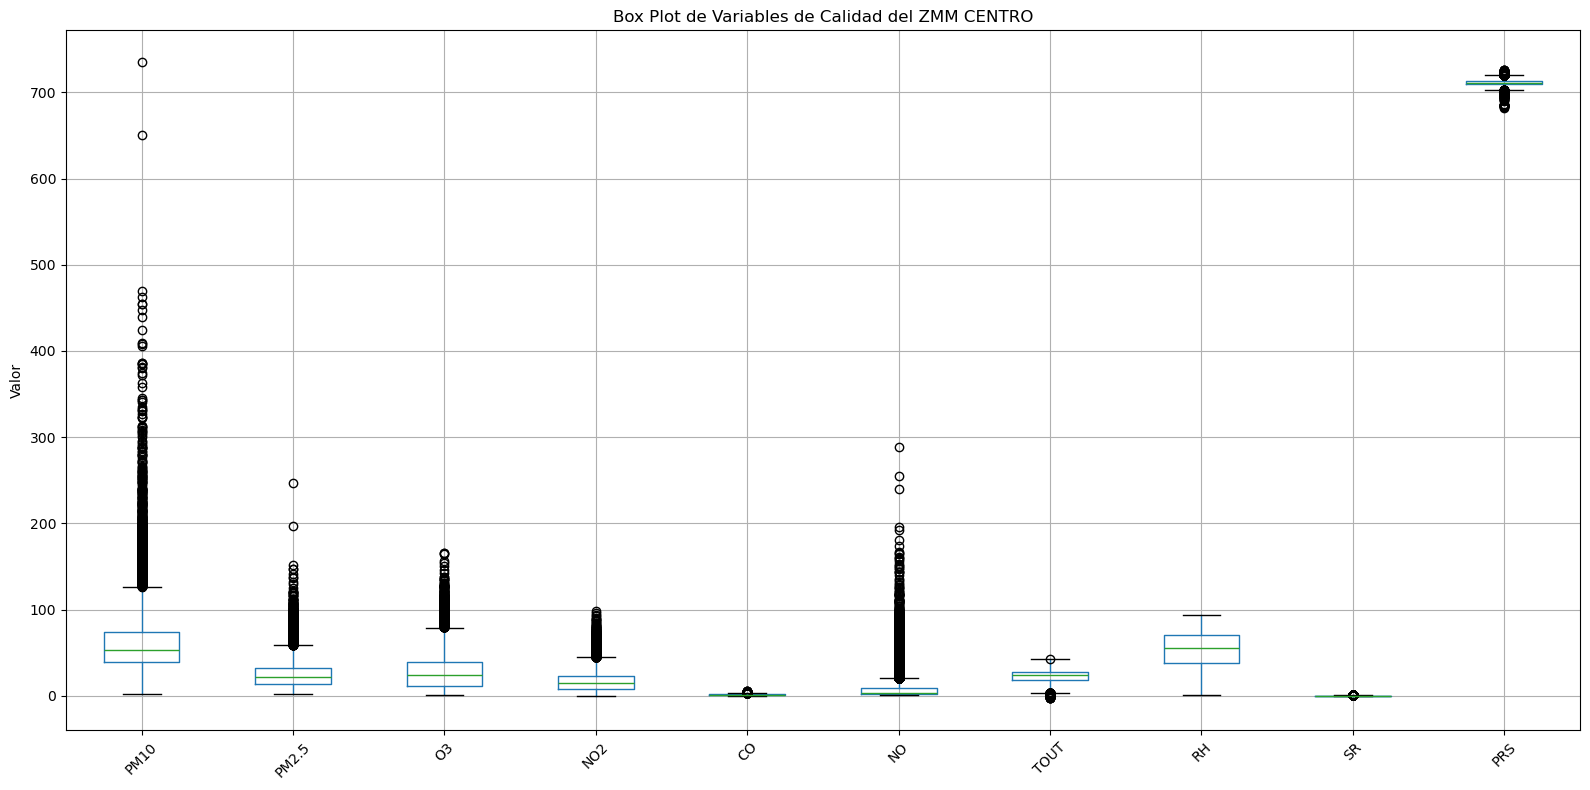

In [56]:
plt.figure(figsize=(16, 8))
df[cols_to_plot].boxplot()
plt.title("Box Plot de Variables de Calidad del ZMM CENTRO")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

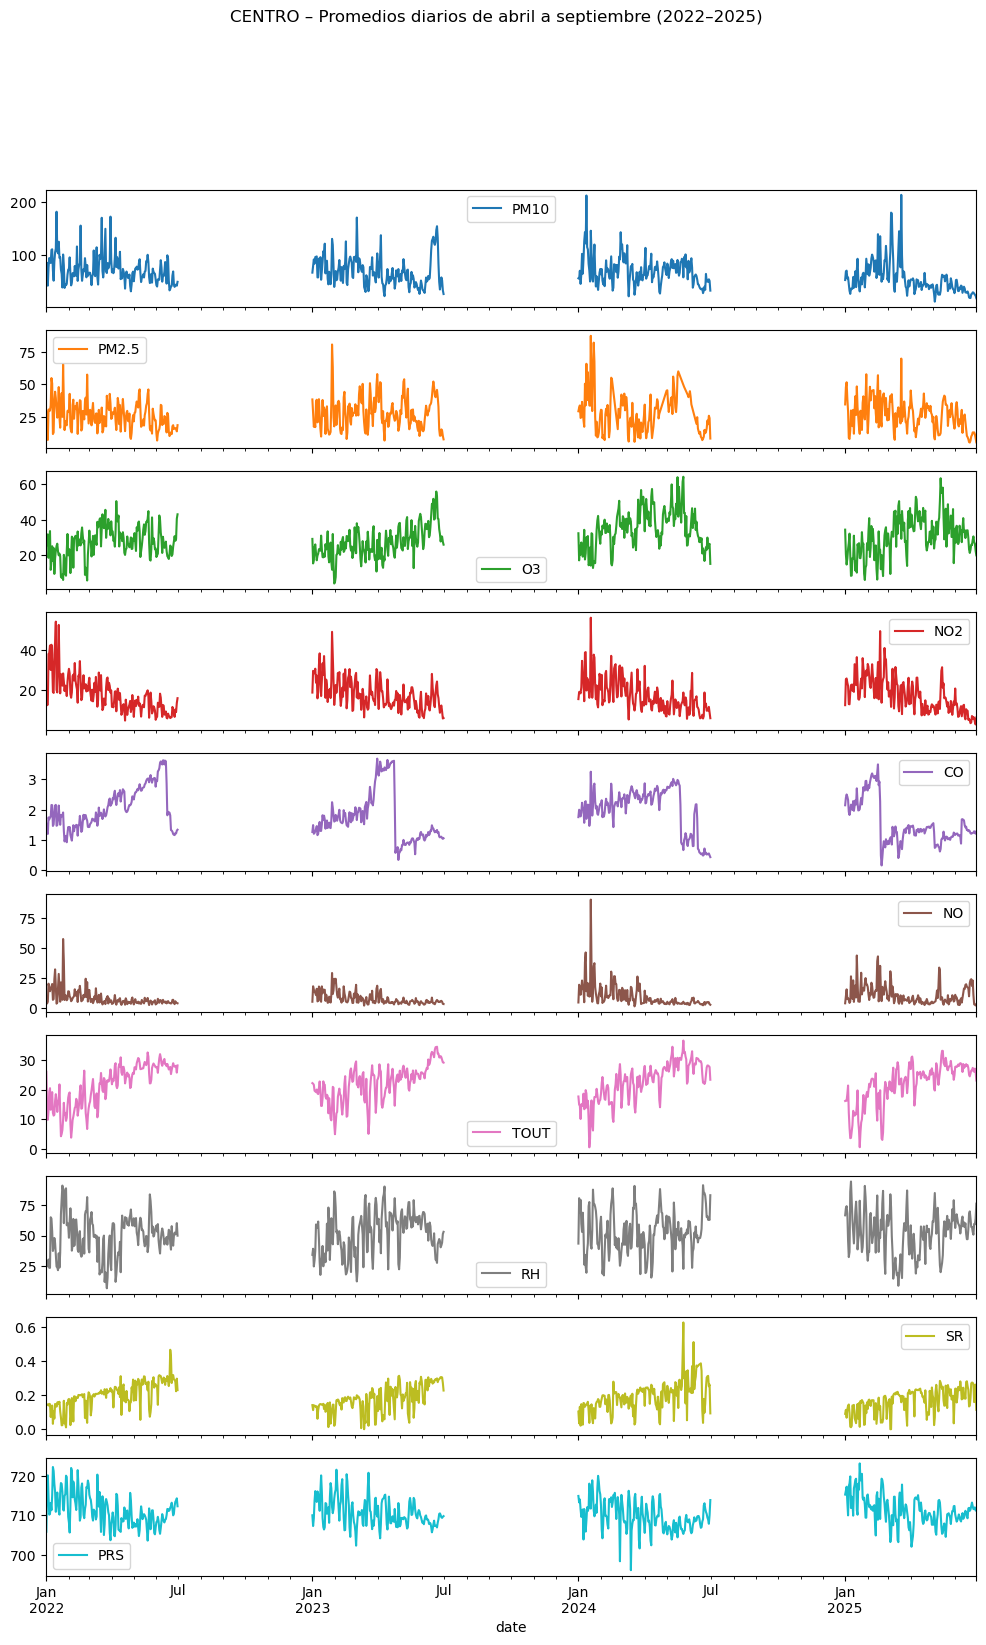

In [57]:
# Extraer solo los datos entre abril y septiembre de cada año
df_periodo = df[(df.index.month >= 1) & (df.index.month <= 6)]

df_periodo[cols_to_plot].resample("D").mean().plot(subplots=True, figsize=(12, 18), sharex=True)
plt.suptitle("CENTRO – Promedios diarios de abril a septiembre (2022–2025)")
plt.show()
